<a id="1"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Semi-Empirical Model</p>
## Objective:
 + Doing Non-Linear Least Square Adjustment for the Soil Moisture

### Ulaby's Water Cloud Model

#### $${Pr_{eff}} = [({A{V_1}cos𝛉})(1-{𝐞^{\frac{−2B{V_2}}{cos𝛉}}})]+({{C}{M_v}+{D}}){𝐞^{\frac{−2B{V_2}}{cos𝛉}}}$$
Where,
$$ {V_1} = {L}^{E_1} $$
 
$$ {V_2} = {L}^{E_2} $$
+ L = Biomass data calculated from LAI
+ 𝛉 = CYGNSS specular point incidence angle
+ Preff = Backscatter from CYGNSS
+ Mv = Soil Moisture 
+ V1 and V2 describe the effect of canopy geometry and water content on the backscatter coefficient. 
+ A and B are vegetation parameters, A corresponds to the albedo of the vegetation and B is an attenuation factor. 
+ C and D are soil parameters, D indicates the sensitivity of the radar signal to soil moisture and C  the calibration constant.

<a id="1"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Non-linear least square adjustment</p>
   + Performing adjustment for the daily soil moisture in a particular 36 km grid cell of SMAP
   + Actually number of parameters to be estimated was 7 (A, B, C, D, E1, E2 and Mvt)
   + Minimum number of observations required should be more than 7 for the adjustment in daily data
   + So in order to account for the day with the low number of observations I have applied adjustment for whole year data
     + I have gathered those days having at least 1 observation
     + ${Mv}_t$ was not considered for the day having no observations
     + Parameters were nD+6
        + Where nD = Number of all days soil moisture as parameters which has at least one observation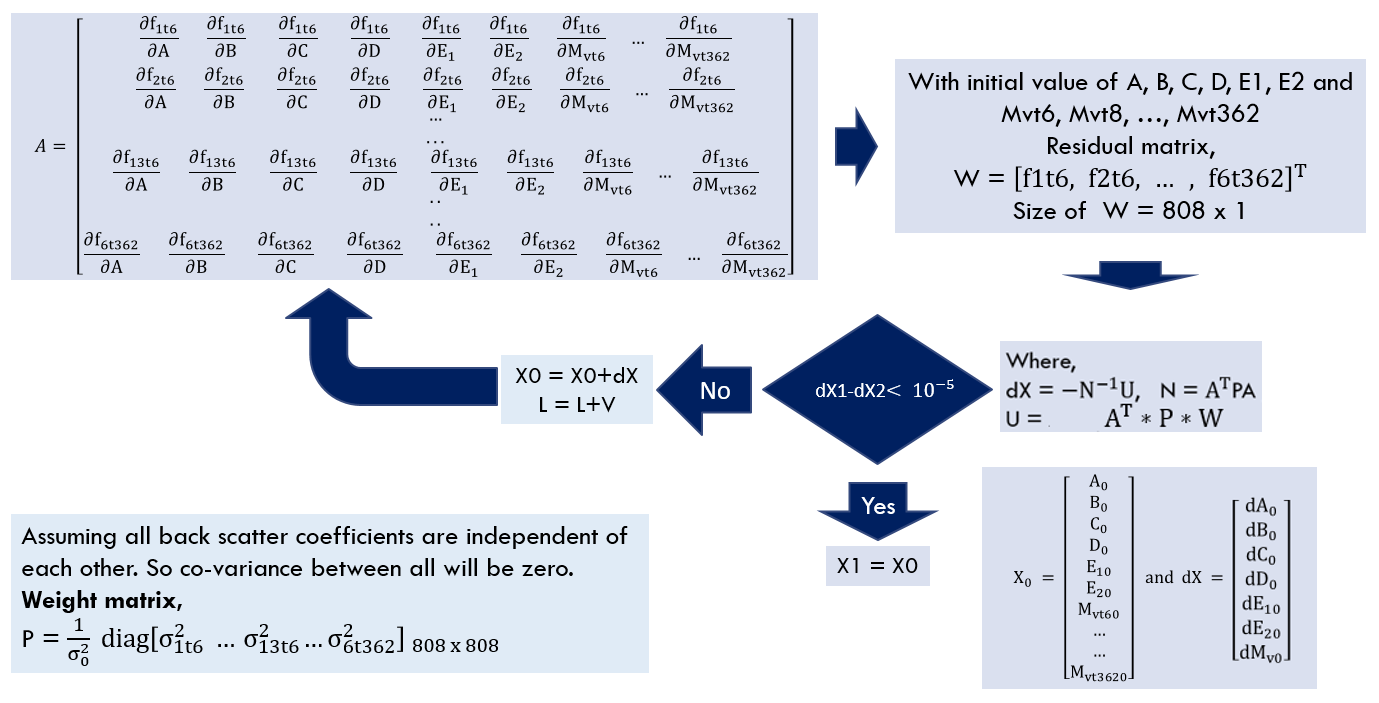

#### Loading Module

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import seaborn as sns
import sympy
from sympy import *

In [2]:
import Preparing_Dataset_for_BatchProcessing
import imp
imp.reload(Preparing_Dataset_for_BatchProcessing)
import Preparing_Dataset_for_BatchProcessing as r5

#### Collecting one year data within a 36 km grid cell
+ CYGNSS daily observations were collected within 36 km grid cell (more than 7 observations were seen in a single day).
+ LAI from NOAA were taken and interpolated along the CYGNSS observations.

#### Stacking all the samples within a particular grid cell for whole year of 2020

In [3]:
lat = 23.62   # Latitude of the centroid of the grid cell
lon = 78.22   # Longitude of the centroid of the grid cell

# Calling Stacking function from the module
DF_batch = r5.Data_Batch_2020(lat,lon)

In [4]:
# Stacked data of the whole year for a single 36 km grid cell
DF_batch

,SR_eff,SP_I,sp_lat,sp_lon,LAI,Day_No
0,6.038855,23.059137,23.690813,78.065280,0.881,1.0
1,4.631810,23.067894,23.704811,78.091160,0.896,1.0
2,5.398931,23.076675,23.718813,78.117065,0.877,1.0
3,4.923258,23.085495,23.732817,78.142960,0.877,1.0
4,5.827567,23.094381,23.746794,78.168884,0.932,1.0
...,...,...,...,...,...,...
11,1.736492,23.198532,23.745024,78.254050,0.000,365.0
12,1.791297,23.174530,23.758152,78.280110,0.000,365.0
13,1.481883,23.150581,23.771260,78.306160,0.000,365.0
14,1.204441,23.126648,23.784369,78.332220,0.000,365.0


+ So in a single grid cell there are 10 observations daily 

### Resampling GLDAS data for initialization purpose 
+ GLDAS soil moisture data were resampled into 36 km grid cell of SMAP.
+ Since SMAP validation data for the adjusted soil moisture is available in 36 km grid cell.

In [5]:
# Path of the resampled GLDAS soil moisture data
GLDAS_Path = f'D:\EG\Project Data\CYGNSS_Obs_Chambal_{lat}_{lon}'+f'\GLDAS_SM_{lat}_{lon}_Day_1-366.csv'
GLDAS_SM1  = pd.read_csv(GLDAS_Path)

# Droping irrelevant variables
GLDAS_SM1  = GLDAS_SM1.drop(np.array(GLDAS_SM1.keys())[:-1],axis=1)
GLDAS_SM   = np.array(GLDAS_SM1['GLDAS_SM'])
Mv0        = GLDAS_SM

### Tagging the daily soil moisture their daily CYGNSS observations

In [6]:
SM_initialized = []
for i in range(len(DF_batch)):
    D = np.array(DF_batch['Day_No'])[i]-1
    SM_initialized.append(Mv0[int(D)])

DF_batch['GLDAS_SM'] = SM_initialized

# Looking observations in 36 km grid cell for a particular day; say 6th January
DF_batch[DF_batch['Day_No']==6]

,SR_eff,SP_I,sp_lat,sp_lon,LAI,Day_No,GLDAS_SM
0,1.338698,12.005059,23.538832,78.059140,0.0,6.0,0.669943
1,1.101488,11.969226,23.526140,78.085160,0.0,6.0,0.669943
2,0.773465,11.861786,23.488018,78.163140,0.0,6.0,0.669943
3,0.700457,11.825986,23.475307,78.189125,0.0,6.0,0.669943
4,1.106099,11.790198,23.462587,78.215100,0.0,6.0,0.669943
5,1.409840,11.754416,23.449860,78.241070,0.0,6.0,0.669943


### Extracting biomass from LAI
+ Calculation of Biomass from the Leaf Area Index data

In [7]:
def LAI_L(LAI):
    LAI_F     = 2.1
    SLA       = 30
    wd_fract  = 0.25
    LAI_MX    = 2.5
    foliar_W  = 1.30
    wood_W    = 0.54
    foliar_C  = LAI*LAI_F/SLA
    wood_C    = wd_fract*LAI_MX*1.25
    veg_water = foliar_C*2.22*foliar_W + wood_C*2.22*wood_W
    L         = 2.22*foliar_C + 2.22*wood_C + veg_water
    return L

+ Counting the number of unique days available within a single 36 km grid cell having CYGNSS observations

In [8]:
Df1 = DF_batch
DD  = (Df1['Day_No'])
DD  = DD.drop_duplicates()
DD

0      1.0
0      2.0
0      3.0
0      4.0
0      5.0
     ...  
0    361.0
0    362.0
0    363.0
0    364.0
0    365.0
Name: Day_No, Length: 252, dtype: float64

+ So here total 252 unique days are available for adjustment
+ Therefore we will have 252 soil moisture data after adjustment

### Collecting raw observations for adjustment

In [9]:
Sgma0    = Df1['SR_eff']       # CYGNSS back-scatter
L        = LAI_L(Df1['LAI'])   # Biomass data from LAI 
Theta    = Df1['SP_I']         # CYGNSS inclination angle 
GLDAS_SM = Df1['GLDAS_SM']     # GLDAS soil moisture data for the initialization purpose
Day_No   = Df1['Day_No']       # Unique days so that the initialization tagged appropriately

#### Ulaby's semi-empirical Water Cloud Model Equation for the adjustment
$${Pr_{eff}} = [({A{V_1}cos𝛉})(1-{𝐞^{\frac{−2B{V_2}}{cos𝛉}}})]+({{C}{M_v}+{D}}){𝐞^{\frac{−2B{V_2}}{cos𝛉}}}$$

In [10]:
a,b,c,d,e1,e2,Mvt,Sgma,theeta,l = symbols('a b c d e1 e2 Mvt Sgma theeta l')

exp1 = a*((l)**e1)*cos(theeta)*(1-exp(-2*b*((l)**e2)/cos(theeta)))
exp2 = c*Mvt*exp(-2*b*((l)**e2)/cos(theeta))
exp3 = d*exp(-2*b*((l)**e2)/cos(theeta))
f    = Sgma-(exp1+exp2+exp3)
f

-Mvt*c*exp(-2*b*l**e2/cos(theeta)) + Sgma - a*l**e1*(1 - exp(-2*b*l**e2/cos(theeta)))*cos(theeta) - d*exp(-2*b*l**e2/cos(theeta))

### Model Parameters (n, u, r, P)
+ n = number of observations
+ r = redundancy 
+ u = number of unknowns
+ P = weight matrix (assumed as identity giving equal weights to all the observations)

In [11]:
def Adjustment_Parameters(Sgma0,DD):
    P = np.identity(len(Sgma0))         # Weight matrix (Precision matrix)
    n = len(Sgma0)                      # As total n erroneous observations are there  
    
    # We have to calculate the model parameters and soil moisture 
    u = 6+len(DD)   # A, B, C, D, E1, E2, Mvt6, Mvt8, ....., Mvt365 Assume those day soil moisture only having Biomass
    r = n-u         # Redundancy
    return P,n,u,r

P,n,u,r = Adjustment_Parameters(Sgma0,DD)
P,n,u,r

(array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 1.]]),
 3449,
 258,
 3191)

### Generating Design Matrix
#### Deriving the Jacobian

In [12]:
def Der(f,var):
    A1 = (Derivative(f,var)).doit()
    return A1

def Design_Matrix(Df1,a,b,c,d,e1,e2,Mvt,DD):
    C1 = Der(f,a)
    C2 = Der(f,b)
    C3 = Der(f,c)
    C4 = Der(f,d)
    C5 = Der(f,e1)
    C6 = Der(f,e2)
    C7 = Der(f,Mvt)
    A1 = []
    for j in range(len(Df1)):
        Single_Row_A = [C1,C2,C3,C4,C5,C6]
        for i in range(len(DD)):
            d1 = np.array(DD)[i]
            d2 = int(np.array(Df1['Day_No'])[j])
            if d1 == d2:
                Single_Row_A += [C7]
            else:
                Single_Row_A += [0]
        A1 += Single_Row_A
    A2 = np.array(A1)
    A1 = A2.reshape(len(Df1),(len(DD)+6))
    return A1

In [13]:
%%time
A1 = Design_Matrix(Df1,a,b,c,d,e1,e2,Mvt,DD)
pd.DataFrame(A1)

Wall time: 12 s


,0,1,2,3,4,5,6,7,8,9,...,248,249,250,251,252,253,254,255,256,257
0,-l**e1*(1 - exp(-2*b*l**e2/cos(theeta)))*cos(t...,2*Mvt*c*l**e2*exp(-2*b*l**e2/cos(theeta))/cos(...,-Mvt*exp(-2*b*l**e2/cos(theeta)),-exp(-2*b*l**e2/cos(theeta)),-a*l**e1*(1 - exp(-2*b*l**e2/cos(theeta)))*log...,2*Mvt*b*c*l**e2*exp(-2*b*l**e2/cos(theeta))*lo...,-c*exp(-2*b*l**e2/cos(theeta)),0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-l**e1*(1 - exp(-2*b*l**e2/cos(theeta)))*cos(t...,2*Mvt*c*l**e2*exp(-2*b*l**e2/cos(theeta))/cos(...,-Mvt*exp(-2*b*l**e2/cos(theeta)),-exp(-2*b*l**e2/cos(theeta)),-a*l**e1*(1 - exp(-2*b*l**e2/cos(theeta)))*log...,2*Mvt*b*c*l**e2*exp(-2*b*l**e2/cos(theeta))*lo...,-c*exp(-2*b*l**e2/cos(theeta)),0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-l**e1*(1 - exp(-2*b*l**e2/cos(theeta)))*cos(t...,2*Mvt*c*l**e2*exp(-2*b*l**e2/cos(theeta))/cos(...,-Mvt*exp(-2*b*l**e2/cos(theeta)),-exp(-2*b*l**e2/cos(theeta)),-a*l**e1*(1 - exp(-2*b*l**e2/cos(theeta)))*log...,2*Mvt*b*c*l**e2*exp(-2*b*l**e2/cos(theeta))*lo...,-c*exp(-2*b*l**e2/cos(theeta)),0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-l**e1*(1 - exp(-2*b*l**e2/cos(theeta)))*cos(t...,2*Mvt*c*l**e2*exp(-2*b*l**e2/cos(theeta))/cos(...,-Mvt*exp(-2*b*l**e2/cos(theeta)),-exp(-2*b*l**e2/cos(theeta)),-a*l**e1*(1 - exp(-2*b*l**e2/cos(theeta)))*log...,2*Mvt*b*c*l**e2*exp(-2*b*l**e2/cos(theeta))*lo...,-c*exp(-2*b*l**e2/cos(theeta)),0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-l**e1*(1 - exp(-2*b*l**e2/cos(theeta)))*cos(t...,2*Mvt*c*l**e2*exp(-2*b*l**e2/cos(theeta))/cos(...,-Mvt*exp(-2*b*l**e2/cos(theeta)),-exp(-2*b*l**e2/cos(theeta)),-a*l**e1*(1 - exp(-2*b*l**e2/cos(theeta)))*log...,2*Mvt*b*c*l**e2*exp(-2*b*l**e2/cos(theeta))*lo...,-c*exp(-2*b*l**e2/cos(theeta)),0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3444,-l**e1*(1 - exp(-2*b*l**e2/cos(theeta)))*cos(t...,2*Mvt*c*l**e2*exp(-2*b*l**e2/cos(theeta))/cos(...,-Mvt*exp(-2*b*l**e2/cos(theeta)),-exp(-2*b*l**e2/cos(theeta)),-a*l**e1*(1 - exp(-2*b*l**e2/cos(theeta)))*log...,2*Mvt*b*c*l**e2*exp(-2*b*l**e2/cos(theeta))*lo...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-c*exp(-2*b*l**e2/cos(theeta))
3445,-l**e1*(1 - exp(-2*b*l**e2/cos(theeta)))*cos(t...,2*Mvt*c*l**e2*exp(-2*b*l**e2/cos(theeta))/cos(...,-Mvt*exp(-2*b*l**e2/cos(theeta)),-exp(-2*b*l**e2/cos(theeta)),-a*l**e1*(1 - exp(-2*b*l**e2/cos(theeta)))*log...,2*Mvt*b*c*l**e2*exp(-2*b*l**e2/cos(theeta))*lo...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-c*exp(-2*b*l**e2/cos(theeta))
3446,-l**e1*(1 - exp(-2*b*l**e2/cos(theeta)))*cos(t...,2*Mvt*c*l**e2*exp(-2*b*l**e2/cos(theeta))/cos(...,-Mvt*exp(-2*b*l**e2/cos(theeta)),-exp(-2*b*l**e2/cos(theeta)),-a*l**e1*(1 - exp(-2*b*l**e2/cos(theeta)))*log...,2*Mvt*b*c*l**e2*exp(-2*b*l**e2/cos(theeta))*lo...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-c*exp(-2*b*l**e2/cos(theeta))
3447,-l**e1*(1 - exp(-2*b*l**e2/cos(theeta)))*cos(t...,2*Mvt*c*l**e2*exp(-2*b*l**e2/cos(theeta))/cos(...,-Mvt*exp(-2*b*l**e2/cos(theeta)),-exp(-2*b*l**e2/cos(theeta)),-a*l**e1*(1 - exp(-2*b*l**e2/cos(theeta)))*log...,2*Mvt*b*c*l**e2*exp(-2*b*l**e2/cos(theeta))*lo...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-c*exp(-2*b*l**e2/cos(theeta))


### Substituting values in Jacobian to get the design matrix

In [14]:
def Resubstituting_Values(A1,Sgma0,L,Theta,SM_GLDAS,a0,b0,c0,d0,e10,e20):
    n1,n2 = A1.shape
    A_1   = []
    for i in range(n1):
        Sgma1  = np.array(Sgma0)[i]
        L1     = np.array(L)[i]
        Theta1 = np.array(Theta)[i]
        Mv0    = np.array(SM_GLDAS)[i]
        for j in range(n2):
            a1 = A1[i][j]
            if a1!=0:
                aij = a1.subs({Sgma:Sgma1,l:L1,theeta:Theta1,Mvt:Mv0,a:a0,b:b0,c:c0,d:d0,e1:e10,e2:e20})
                A_1.append(aij)
            else:
                A_1.append(0)
    A_1 = np.array(A_1)    
    A1  = A_1.reshape(n1,n2)
    A   = pd.DataFrame(np.array(A1))
    A.to_csv(rf'D:\EG\Project Data\A_WCM.csv',index=False)
    A   = np.array(pd.read_csv(rf'D:\EG\Project Data\A_WCM.csv'))
    return A

### Setting initial values to the Model parameters 
+ Used Hit and Trail Method to approximate these values

In [15]:
a0    = 0.0094645
b0    = 0.09645
c0    = 13.92
d0    = 0
e10   = -5
e20   = -190       

### Adding the initialized soil moisture 

In [16]:
SM_initial = np.array(DF_batch['GLDAS_SM'].drop_duplicates())
X0         = [a0,b0,c0,d0,e10,e20]
for i in range(len(SM_initial)):
    X0.append(SM_initial[i])
pd.DataFrame(X0)

,0
0,0.009465
1,0.096450
2,13.920000
3,0.000000
4,-5.000000
...,...
253,0.623587
254,0.619572
255,0.617998
256,0.616732


+ X0 is the Initial Parameter vector

In [17]:
%%time
A = Resubstituting_Values(A1,Sgma0,L,Theta,GLDAS_SM,a0,b0,c0,d0,e10,e20)
pd.DataFrame(A)

Wall time: 39.2 s


,0,1,2,3,4,5,6,7,8,9,...,248,249,250,251,252,253,254,255,256,257
0,0.0,-2.250699e-89,-0.712536,-1.0,0.0,-2.374585e-90,-13.92,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
1,0.0,-1.626574e-89,-0.712536,-1.0,0.0,-1.718920e-90,-13.92,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
2,0.0,-2.546718e-89,-0.712536,-1.0,0.0,-2.685722e-90,-13.92,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
3,0.0,-2.590140e-89,-0.712536,-1.0,0.0,-2.731514e-90,-13.92,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
4,0.0,-7.570697e-90,-0.712536,-1.0,0.0,-8.031856e-91,-13.92,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3444,0.0,-4.144186e-80,-0.616134,-1.0,0.0,-3.926837e-81,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-13.92
3445,0.0,-3.899242e-80,-0.616134,-1.0,0.0,-3.694740e-81,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-13.92
3446,0.0,-3.684089e-80,-0.616134,-1.0,0.0,-3.490870e-81,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-13.92
3447,0.0,-3.493456e-80,-0.616134,-1.0,0.0,-3.310236e-81,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-13.92


### Deriving the residual vector for all the observation equations
+ After substituting the initial parameters and the observations 
+ Derived the residual vector for adjustment

In [18]:
## Residual vector also called as Misclosure
def Misclosure(Sgma0,L,Theta,SM_GLDAS,a0,b0,c0,d0,e10,e20,f):
    W_0 = []
    for i in range(len(Sgma0)):
        Sgma1  = np.array(Sgma0)[i]
        L1     = np.array(L)[i]
        Theta1 = np.array(Theta)[i]
        Mv0    = np.array(SM_GLDAS)[i]
        f5 = f.subs({Sgma:Sgma1,l:L1,theeta:Theta1,Mvt:Mv0,a:a0,b:b0,c:c0,d:d0,e1:e10,e2:e20})
        W_0.append(f5)
    W_0 = np.array(W_0)
    W1  = W_0.reshape(len(Sgma0),1)
    W   = pd.DataFrame(W1)
    
    W.to_csv(rf'D:\EG\Project Data\W_WCM.csv',index = False)
    W   = pd.read_csv(rf'D:\EG\Project Data\W_WCM.csv')
    W   = (np.array(W))
    return W

In [19]:
%%time
W = Misclosure(Sgma0,L,Theta,GLDAS_SM,a0,b0,c0,d0,e10,e20,f)
pd.DataFrame(W)

Wall time: 20.9 s


,0
0,-3.879639
1,-5.286684
2,-4.519563
3,-4.995237
4,-4.090927
...,...
3444,-6.840092
3445,-6.785287
3446,-7.094700
3447,-7.372143


+ Since residuals are very high in the observed back-scatter so we need to adjust

### Finding Normal Matrix

In [20]:
%%time
N = np.array(np.transpose(A)@P@A)
N.shape

Wall time: 120 ms


(258, 258)

#### Converting the elements of the matrix from the object to the float

In [21]:
def Object_toFloat(Matrix):
    m,n = Matrix.shape
    M1 = []
    for i in range(m):
        for j in range(n):
            M1.append(float(Matrix[i,j]))
    M2 = np.array(M1)
    M = M2.reshape(m,n)
    return M

In [22]:
N = Object_toFloat(N)
pd.DataFrame(N)

,0,1,2,3,4,5,6,7,8,9,...,248,249,250,251,252,253,254,255,256,257
0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,0.0,4.228889e-152,1.518969e-76,2.389511e-76,0.0,4.007098e-153,1.380570e-87,2.597574e-86,-1.399211e-87,1.590949e-77,...,-5.945595e-79,7.501773e-79,5.840141e-78,2.972170e-78,1.933794e-78,1.171604e-83,-7.237761e-86,-1.828319e-79,-1.625733e-78,3.113983e-78
2,0.0,1.518969e-76,1.382282e+03,2.136086e+03,0.0,1.439305e-77,7.934796e+01,7.909745e+01,1.048333e+02,2.542232e+02,...,7.121464e+01,7.056996e+01,1.580005e+02,7.859595e+01,6.963466e+01,6.944269e+01,1.293666e+02,2.580758e+01,1.201887e+02,1.372253e+02
3,0.0,2.389511e-76,2.136086e+03,3.449000e+03,0.0,2.264189e-77,1.113600e+02,1.113600e+02,1.531200e+02,3.758400e+02,...,1.113600e+02,1.113600e+02,2.505600e+02,1.252800e+02,1.113600e+02,1.113600e+02,2.088000e+02,4.176000e+01,1.948800e+02,2.227200e+02
4,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,0.0,1.171604e-83,6.944269e+01,1.113600e+02,0.0,1.177088e-84,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.550131e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
254,0.0,-7.237761e-86,1.293666e+02,2.088000e+02,0.0,-7.409596e-87,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.906496e+03,0.000000e+00,0.000000e+00,0.000000e+00
255,0.0,-1.828319e-79,2.580758e+01,4.176000e+01,0.0,-1.732430e-80,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.812992e+02,0.000000e+00,0.000000e+00
256,0.0,-1.625733e-78,1.201887e+02,1.948800e+02,0.0,-1.540469e-79,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.712730e+03,0.000000e+00


In [23]:
%%time
U = (np.transpose(A))@P@W
U

Wall time: 96.7 ms


array([[ 0.00000000e+00],
       [ 1.52261460e-75],
       [ 1.04621703e+04],
       [ 1.66695854e+04],
       [ 0.00000000e+00],
       [ 1.44275870e-76],
       [ 5.58764302e+02],
       [ 7.79758001e+02],
       [ 9.33657804e+02],
       [ 2.10102998e+03],
       [ 2.02164236e+03],
       [ 6.89368844e+02],
       [ 1.26558500e+03],
       [ 1.76067601e+03],
       [ 9.74666890e+02],
       [ 8.42007582e+02],
       [ 2.42842880e+03],
       [ 1.43895268e+02],
       [ 4.56086644e+02],
       [ 3.23757433e+02],
       [ 1.72039054e+03],
       [ 1.99371081e+03],
       [ 2.12896023e+03],
       [ 6.61880395e+02],
       [ 3.82532350e+02],
       [ 7.07013528e+02],
       [ 2.07136951e+03],
       [ 1.05521439e+03],
       [ 2.74558245e+03],
       [ 9.10467176e+02],
       [ 3.43372898e+02],
       [ 1.85602922e+03],
       [ 2.06320137e+03],
       [ 2.14117517e+03],
       [ 2.94332143e+02],
       [ 1.70092010e+03],
       [ 9.90444459e+02],
       [ 8.15601145e+01],
       [ 2.3

### Updates in the parameters

In [24]:
Part1  = np.linalg.pinv(N)       ## Inverse of N
Part2  = Object_toFloat(Part1)   ## Converting elements to float
dX     = -Part2@U                ## Change in X

In [25]:
np.max(abs(dX))

2.2028023081560826

In [26]:
X0 = np.array(X0)
X0 = X0.reshape(len(X0),1)
X  = X0+dX
X

array([[ 9.46450000e-03],
       [ 9.64500000e-02],
       [ 1.25173668e+01],
       [-2.20280231e+00],
       [-5.00000000e+00],
       [-1.90000000e+02],
       [ 5.82118075e-01],
       [ 4.37077417e-01],
       [ 4.73840293e-01],
       [ 5.01221977e-01],
       [ 4.03268674e-01],
       [ 3.02741501e-01],
       [ 3.87645653e-01],
       [ 3.82847178e-01],
       [ 4.97172752e-01],
       [ 3.96351392e-01],
       [ 4.71210527e-01],
       [ 5.17129401e-01],
       [ 3.17743337e-01],
       [ 3.23155464e-01],
       [ 5.70320745e-01],
       [ 3.38352038e-01],
       [ 3.59723524e-01],
       [ 3.05623174e-01],
       [ 5.42929018e-01],
       [ 4.12778976e-01],
       [ 3.78462379e-01],
       [ 3.12118745e-01],
       [ 3.50474474e-01],
       [ 3.81178041e-01],
       [ 4.90585862e-01],
       [ 3.11415516e-01],
       [ 3.90817326e-01],
       [ 3.82288631e-01],
       [ 3.34137690e-01],
       [ 4.14782363e-01],
       [ 4.38133663e-01],
       [ 4.07641273e-01],
       [ 4.2

### Creating Index for updating soil moisture

In [27]:
Df = pd.DataFrame(DF_batch['Day_No'].value_counts(sort=False))['Day_No']
DD = Df.values
idx = []
m = 0
for i in range(len(DD)):
    j = DD[i]
    for k in range(j):
        idx.append(m)
    m = m+1
np.array(idx).shape

(3449,)

### 1st Iteration

In [28]:
X_SM = X[6:]
X_SM.shape

(252, 1)

#### Updating soil moisture

In [29]:
def New_SM(DF_batch,X_SM,idx):
    Mv0 = X_SM
    DF_batch = DF_batch.drop(['GLDAS_SM'], axis=1)
    SM_initialized = []
    for i in range(len(DF_batch)):
        D  = int(np.array(idx)[i])
        SM = Mv0[D]
        SM_initialized.append(SM)
    SM_initialized = np.array(SM_initialized).reshape(len(SM_initialized),) 
    return SM_initialized

In [30]:
%%time
GLDAS_SM = New_SM(DF_batch,X_SM,idx)
A        = Resubstituting_Values(A1,Sgma0,L,Theta,GLDAS_SM,X[0][0],X[1][0],X[2][0],X[3][0],X[4][0],X[5][0])
W        = Misclosure(Sgma0,L,Theta,GLDAS_SM,X[0][0],X[1][0],X[2][0],X[3][0],X[4][0],X[5][0],f)
N        = np.array(np.transpose(A)@P@A)
U        = (np.transpose(A))@P@W
N        = Object_toFloat(N)
Part1    = np.linalg.pinv(N)       ## Inverse of N
Part2    = Object_toFloat(Part1)   ## Converting elements to float
dX1      = -Part2@U                ## Change in X

Wall time: 1min 9s


#### Setting threshold to stop the adjustment

In [31]:
np.max(abs(dX1-dX))<10**(-5)

False

+ Subsequent change in the parameters is more than the threshold so we need to perform more iterations here

#### Updated parameters for next iteration

In [32]:
X = X+dX1
X

array([[ 9.46450000e-03],
       [ 9.64500000e-02],
       [ 1.25234648e+01],
       [-2.30986089e+00],
       [-5.00000000e+00],
       [-1.90000000e+02],
       [ 5.75773366e-01],
       [ 4.14802905e-01],
       [ 4.58540201e-01],
       [ 4.89899549e-01],
       [ 3.81294834e-01],
       [ 2.70000022e-01],
       [ 3.64949673e-01],
       [ 3.59861262e-01],
       [ 4.87303602e-01],
       [ 3.75734899e-01],
       [ 4.57949600e-01],
       [ 5.09045370e-01],
       [ 2.85607149e-01],
       [ 2.94278183e-01],
       [ 5.69388485e-01],
       [ 3.11192487e-01],
       [ 3.31976403e-01],
       [ 2.75316746e-01],
       [ 5.39400949e-01],
       [ 3.95044207e-01],
       [ 3.57357588e-01],
       [ 2.84393294e-01],
       [ 3.27045558e-01],
       [ 3.61731789e-01],
       [ 4.83962028e-01],
       [ 2.84948636e-01],
       [ 3.72170452e-01],
       [ 3.63815212e-01],
       [ 3.10520683e-01],
       [ 4.00944597e-01],
       [ 4.27050071e-01],
       [ 3.93437475e-01],
       [ 4.1

### Performing more Iteration

In [33]:
def Adjustment_Parameters(DF_batch,idx,A1,Sgma0,L,Theta,X,f):
    X_SM     = X[6:]
    GLDAS_SM = New_SM(DF_batch,X_SM,idx)
    A        = Resubstituting_Values(A1,Sgma0,L,Theta,GLDAS_SM,X[0][0],X[1][0],X[2][0],X[3][0],X[4][0],X[5][0])
    W        = Misclosure(Sgma0,L,Theta,GLDAS_SM,X[0][0],X[1][0],X[2][0],X[3][0],X[4][0],X[5][0],f)
    N        = np.array(np.transpose(A)@P@A)
    U        = (np.transpose(A))@P@W
    N        = Object_toFloat(N)
    Part1    = np.linalg.pinv(N)       ## Inverse of N
    Part2    = Object_toFloat(Part1)   ## Converting elements to float
    dX       = -Part2@U                ## Change in X
    return A,W,N,U,dX

dX = dX1
for i in range(1,200):
    A,W,N,U,dX1 = Adjustment_Parameters(DF_batch,idx,A1,Sgma0,L,Theta,X,f)
    Thres       = np.max(abs(dX-dX1))
    if Thres<10**(-5):
        A_adjusted  = A
        W_adjusted  = W
        N_adjusted  = N
        U_adjusted  = U
        X_adjusted  = X
        dX_adjusted = dX
        Number_Iteration = i
        break
    else:
        dX = dX1
        X  = X+dX
        
print('Threshold = ',Thres)
print('Total number of iterations = ',Number_Iteration+1)

Threshold =  5.784094554460403e-11
Total number of iterations =  4


#### Final design matrix

In [34]:
A = pd.DataFrame(A_adjusted) 
A

,0,1,2,3,4,5,6,7,8,9,...,248,249,250,251,252,253,254,255,256,257
0,0.0,-1.112101e-89,-0.575775,-1.0,0.0,-1.173315e-90,-12.523447,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,-8.037124e-90,-0.575775,-1.0,0.0,-8.493421e-91,-12.523447,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,-1.258368e-89,-0.575775,-1.0,0.0,-1.327052e-90,-12.523447,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,-1.279824e-89,-0.575775,-1.0,0.0,-1.349679e-90,-12.523447,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.0,-3.740785e-90,-0.575775,-1.0,0.0,-3.968650e-91,-12.523447,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3444,0.0,-6.861243e-81,-0.297824,-1.0,0.0,-6.501394e-82,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-12.523447
3445,0.0,-6.455712e-81,-0.297824,-1.0,0.0,-6.117132e-82,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-12.523447
3446,0.0,-6.099503e-81,-0.297824,-1.0,0.0,-5.779604e-82,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-12.523447
3447,0.0,-5.783890e-81,-0.297824,-1.0,0.0,-5.480544e-82,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-12.523447


#### Final residual matrix

In [35]:
W = pd.DataFrame(W_adjusted) 
W

,0
0,1.138000
1,-0.269045
2,0.498076
3,0.022402
4,0.926712
...,...
3444,0.316547
3445,0.371351
3446,0.061938
3447,-0.215504


#### Final Normal Matrix

In [36]:
N = pd.DataFrame(N_adjusted) 
N

,0,1,2,3,4,5,6,7,8,9,...,248,249,250,251,252,253,254,255,256,257
0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,0.0,4.628435e-153,4.610118e-77,9.257073e-77,0.0,4.385688e-154,6.137195e-88,6.819255e-87,-4.534185e-88,5.815309e-78,...,-1.030707e-79,1.517153e-79,8.482382e-79,5.322157e-79,1.844687e-79,3.832656e-84,-3.088545e-86,-2.983699e-80,-2.679131e-79,4.638492e-79
2,0.0,4.610118e-77,9.587118e+02,1.679359e+03,0.0,4.368327e-78,5.768553e+01,4.155904e+01,6.316838e+01,1.656527e+02,...,3.220124e+01,3.434127e+01,6.708389e+01,3.643155e+01,2.586160e+01,4.372849e+01,9.600812e+01,1.161138e+01,5.435385e+01,5.967649e+01
3,0.0,9.257073e-77,1.679359e+03,3.449000e+03,0.0,8.771565e-78,1.001876e+02,1.001876e+02,1.377579e+02,3.381331e+02,...,1.001876e+02,1.001876e+02,2.254220e+02,1.127110e+02,1.001876e+02,1.001876e+02,1.878517e+02,3.757034e+01,1.753283e+02,2.003751e+02
4,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,0.0,3.832656e-84,4.372849e+01,1.001876e+02,0.0,3.850595e-85,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.254694e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
254,0.0,-3.088545e-86,9.600812e+01,1.878517e+02,0.0,-3.161871e-87,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.352551e+03,0.000000e+00,0.000000e+00,0.000000e+00
255,0.0,-2.983699e-80,1.161138e+01,3.757034e+01,0.0,-2.827214e-81,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.705101e+02,0.000000e+00,0.000000e+00
256,0.0,-2.679131e-79,5.435385e+01,1.753283e+02,0.0,-2.538619e-80,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.195714e+03,0.000000e+00


#### Final adjusted parameters

In [37]:
X = pd.DataFrame(X_adjusted) 
X

,0
0,0.009465
1,0.096450
2,12.523447
3,-2.309836
4,-5.000000
...,...
253,0.436466
254,0.511085
255,0.309057
256,0.310012


#### Subsequent change in the parameters

In [38]:
dX = pd.DataFrame(dX_adjusted)
dX

,0
0,0.000000e+00
1,-4.188216e-26
2,-3.075991e-11
3,2.326435e-11
4,5.935022e-26
...,...
253,5.248716e-12
254,-1.053316e-14
255,1.333836e-11
256,1.318416e-11


### Design Matrix corresponding to WCM Parameters
+ Adjusted WCM parameters (A,B,C,D,$E_1$,$E_2$)

In [39]:
pd.DataFrame(X[:6])

,0
0,0.009465
1,0.096450
2,12.523447
3,-2.309836
4,-5.000000
5,-190.000000


+ Corresponding design matrix

In [40]:
pd.DataFrame(A_adjusted[:,:6])

,0,1,2,3,4,5
0,0.0,-1.112101e-89,-0.575775,-1.0,0.0,-1.173315e-90
1,0.0,-8.037124e-90,-0.575775,-1.0,0.0,-8.493421e-91
2,0.0,-1.258368e-89,-0.575775,-1.0,0.0,-1.327052e-90
3,0.0,-1.279824e-89,-0.575775,-1.0,0.0,-1.349679e-90
4,0.0,-3.740785e-90,-0.575775,-1.0,0.0,-3.968650e-91
...,...,...,...,...,...,...
3444,0.0,-6.861243e-81,-0.297824,-1.0,0.0,-6.501394e-82
3445,0.0,-6.455712e-81,-0.297824,-1.0,0.0,-6.117132e-82
3446,0.0,-6.099503e-81,-0.297824,-1.0,0.0,-5.779604e-82
3447,0.0,-5.783890e-81,-0.297824,-1.0,0.0,-5.480544e-82


### Design Matrix corresponding to the Soil Moisture

+ Adjusted soil moisture

In [41]:
pd.DataFrame(X[6:])

,0
6,0.575775
7,0.414812
8,0.458546
9,0.489904
10,0.381304
...,...
253,0.436466
254,0.511085
255,0.309057
256,0.310012


+ Corresponding design matrix

In [42]:
pd.DataFrame(A_adjusted[:,6:])

,0,1,2,3,4,5,6,7,8,9,...,242,243,244,245,246,247,248,249,250,251
0,-12.523447,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,-12.523447,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,-12.523447,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,-12.523447,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,-12.523447,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3444,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-12.523447
3445,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-12.523447
3446,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-12.523447
3447,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-12.523447


In [43]:
np.linalg.matrix_rank(A_adjusted)

252

<a id="1"></a>
## <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:4px 4px;">Hypothesis Test</p>

In [44]:
S   = np.transpose(W)@P@W/r       ## Sum of the square of the residuals
S02 = np.std(Sgma0)               ## Standard deviation in original observed backscatter

In [45]:
r

3191

+ For 5 % significance level 
  + From look up table critical value:
    + DOF = r , alpha = 0.05
    + Critical value, P = r-1 

In [46]:
Test_Statistic = r*S02/S[0][0]
P = r-1
Test_Statistic<P,Test_Statistic

(True, 2077.3470781609126)

+ Test statistic is less than critical value 

### Orthogonality Test 

In [47]:
V = np.transpose(A)@W 
np.sum(V**2)<10**(-15),np.sum(V**2)

(0    True
 dtype: bool,
 0    2.513072e-23
 dtype: float64)

<a id="1"></a>
## <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:4px 4px;">Validation of Adjusted Soil Moisture</p>

### 1. Improved correlation of adjusted soil moisture with the SMAP soil moisture

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

In [49]:
def Plotting_Var(Df,lat,lon):
    CR = np.array(Df.corr())[1][2]*100
    RMSE = round(np.sum((Df['SMAP_SM'] - Df['Improved_SM'])**2)/len(Df['SMAP_SM']),3)
    plt.figure(figsize=(30,8))
    plt.scatter(Df['Day_No'],Df['Improved_SM'],label='WCM SM after adjustment')
    plt.scatter(Df['Day_No'],Df['SMAP_SM'],label='SMAP SM on the vegetated pixel')
    
    plt.title(f'''Latitude: {lat} Longitude: {lon} RMSE: {round(RMSE,4)} Correlation: {np.round(CR,2)} %''',size=40) 
    plt.xlabel('Day number of the year 2020',size=30)
    plt.ylabel('Volumetric Soil Moisture',size=30)
    plt.ylim(0,1)
    plt.xticks(np.arange(1, 370, 15),size=20)
    plt.yticks(np.arange(0, 1, 0.2),size=20)
    plt.legend(fontsize=30)

    plt.figure(figsize=(8,8))
    sns.lmplot(x=f'SMAP_SM',y=f'Improved_SM',data=Df,line_kws={'color': 'black'})
    plt.xlabel(f'SMAP_SM',size=16)
    plt.ylabel(f'Improved_SM',size=16)
    plt.plot([0,1],[0,1],c='gray')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xticks(np.arange(0, 1, 0.2))
    plt.yticks(np.arange(0, 1, 0.2))
    
def Plotting_Variations(Df,Var1,Var2,label1,label2):
    plt.figure(figsize=(30,8))
    plt.scatter(Df['Day_No'],Df[f'{Var1}'],label = label1)
    plt.scatter(Df['Day_No'],Df[f'{Var2}'],label = label2)
    
    plt.title(f'''Latitude: {lat} Longitude: {lon} RMSE: {round(RMSE,4)} Correlation: {CR} %''',size=40) 
    plt.xlabel('Day number of the year 2020',size=30)
    plt.ylabel('Volumetric Soil Moisture',size=30)
    plt.ylim(0,1)
    plt.xticks(np.arange(1, 370, 15),size=20)
    plt.yticks(np.arange(0, 1, 0.1),size=20)
    plt.legend(fontsize=30)
    
    plt.figure(figsize=(8,8))
    sns.lmplot(x=f'{Var1}',y=f'{Var2}',data=Df,line_kws={'color': 'black'})
    plt.xlabel(f'{Var1}',size=20)
    plt.ylabel(f'{Var2}',size=20)
    plt.plot([0,1],[0,1],c='gray')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xticks(np.arange(0, 1, 0.2),size=20)
    plt.yticks(np.arange(0, 1, 0.2),size=20)

In [50]:
DD1 = DF_batch['Day_No'].drop_duplicates()
DD  = DD1.values
SM_adjusted = X[6:].values

In [51]:
SMAP_SM = pd.read_csv(f'D:\EG\Project Data\CYGNSS_Data_in_0p36Dg\SMAP_RF_SM\SMAP_SM_Variations_{lat}_{lon}.csv')  
SMAP_SM['SMAP_SM'] = SMAP_SM['SMAP_SM']/100
x2      = np.array(SMAP_SM['SMAP_SM'])

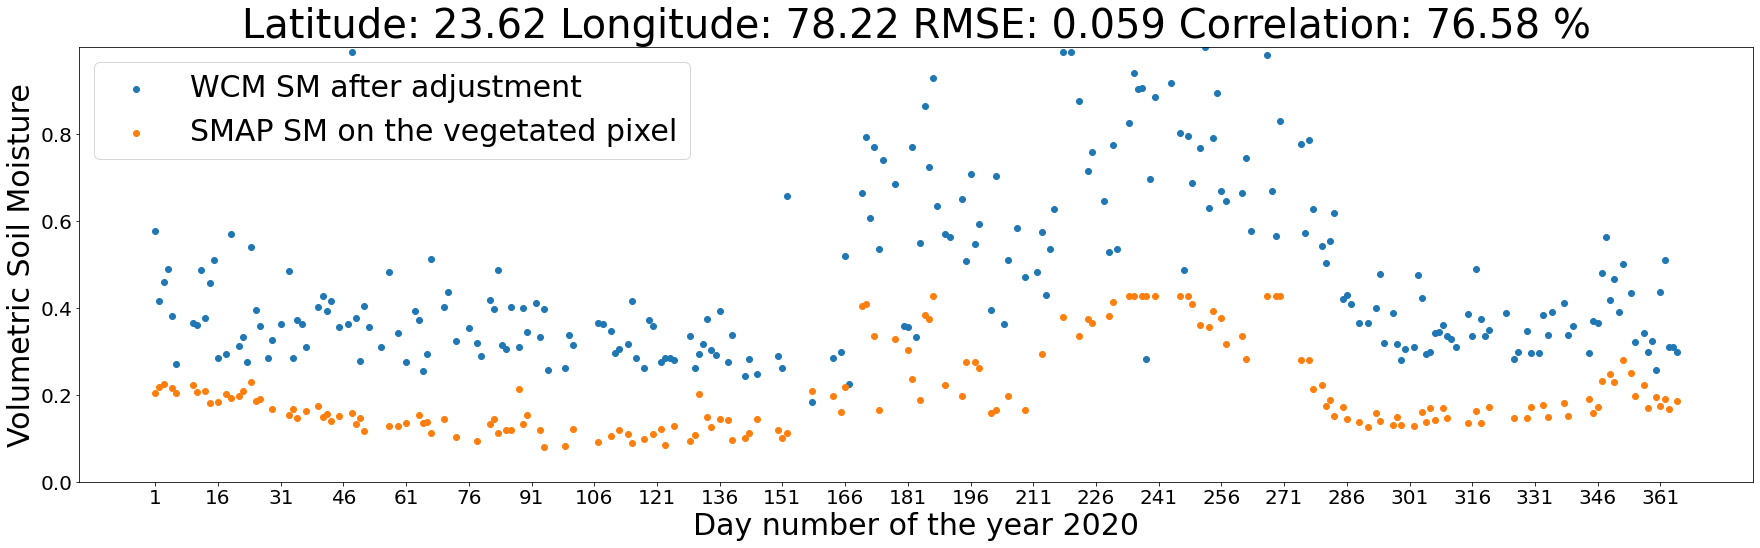

<Figure size 576x576 with 0 Axes>

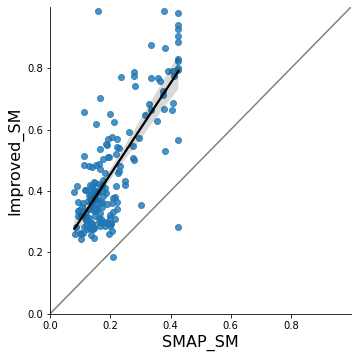

In [52]:
SMAP_SM_filter = []
for j in range(len(DD)):
    D2 = int(DD[j])
    SMAP_SM_filter.append(np.array(SMAP_SM['SMAP_SM'])[D2-1])
    
Df = pd.DataFrame(DD)
Df.columns = ['Day_No'] 
Df['SMAP_SM'] = SMAP_SM_filter
Df['Improved_SM'] = SM_adjusted
Df = Df[(Df['Improved_SM']<1) & (Df['Improved_SM']>=0)]
Plotting_Var(Df,lat,lon)

In [53]:
Df.corr()

,Day_No,SMAP_SM,Improved_SM
Day_No,1.000000,0.257983,0.180561
SMAP_SM,0.257983,1.000000,0.765812
Improved_SM,0.180561,0.765812,1.000000


### 2. Correlation of adjusted soil moisture with the initialized GLDAS soil moisture

In [54]:
def New_SM1(DF_batch,X_SM,idx):
    Mv0 = X_SM
    SM_initialized = []
    for i in range(len(DF_batch)):
        D  = int(np.array(idx)[i])
        SM = float(Mv0[D])
        SM_initialized.append(SM)
    SM_initialized = np.array(SM_initialized).reshape(len(SM_initialized),) 
    DF_batch['WCM_SM'] = SM_initialized
    return DF_batch

X_SM     = X[6:].values
GLDAS_WCM_SM = New_SM1(DF_batch,X_SM,idx)

In [55]:
GLDAS_WCM_SM1 = GLDAS_WCM_SM.drop(['SR_eff','SP_I','sp_lat','sp_lon','LAI'], axis=1)
GLDAS_WCM_SM1 = GLDAS_WCM_SM1.drop_duplicates()
GLDAS_WCM_SM1 = GLDAS_WCM_SM1[GLDAS_WCM_SM1['WCM_SM']<1]
GLDAS_WCM_SM1.corr()

,Day_No,GLDAS_SM,WCM_SM
Day_No,1.000000,0.322087,0.180561
GLDAS_SM,0.322087,1.000000,0.576161
WCM_SM,0.180561,0.576161,1.000000


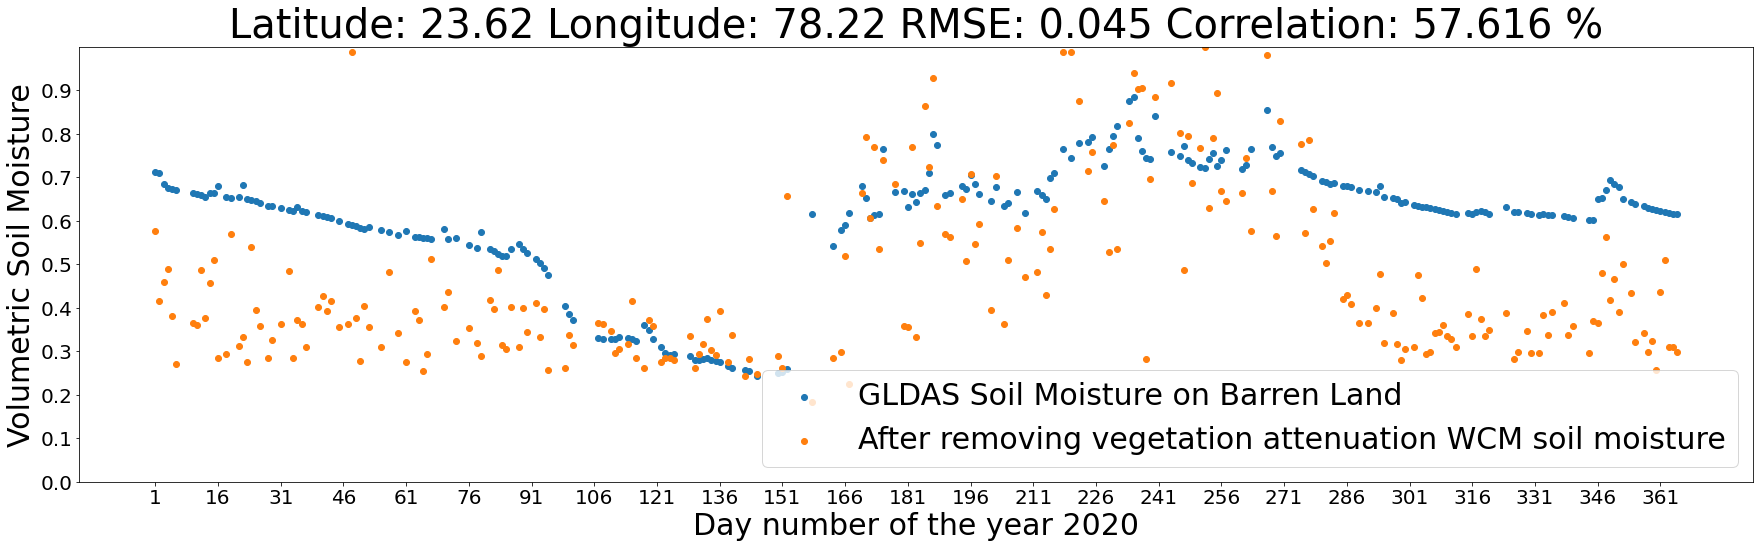

<Figure size 576x576 with 0 Axes>

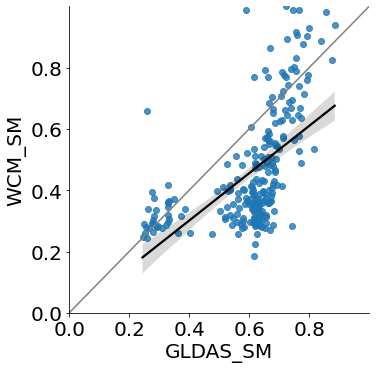

In [56]:
CR = np.array(GLDAS_WCM_SM1.corr())
CR = round((CR[1][2])*100,3)
RMSE = round(np.sum((GLDAS_WCM_SM1['GLDAS_SM'] - GLDAS_WCM_SM1['WCM_SM'])**2)/len(GLDAS_WCM_SM1['GLDAS_SM']),3)

Plotting_Variations(GLDAS_WCM_SM1
                    ,'GLDAS_SM'
                    ,'WCM_SM'
                    ,'GLDAS Soil Moisture on Barren Land'
                    ,'After removing vegetation attenuation WCM soil moisture')

### 3. Correlation of SMAP with initialized GLDAS soil moisture

In [57]:
GLDAS_SM1['Day_No'] = pd.DataFrame(np.array(SMAP_SM['Day_No']))
GLDAS_SM1['SMAP_SM'] = SMAP_SM['SMAP_SM']
GLDAS_SM1.corr()

,GLDAS_SM,Day_No,SMAP_SM
GLDAS_SM,1.000000,0.344229,0.698328
Day_No,0.344229,1.000000,0.294781
SMAP_SM,0.698328,0.294781,1.000000


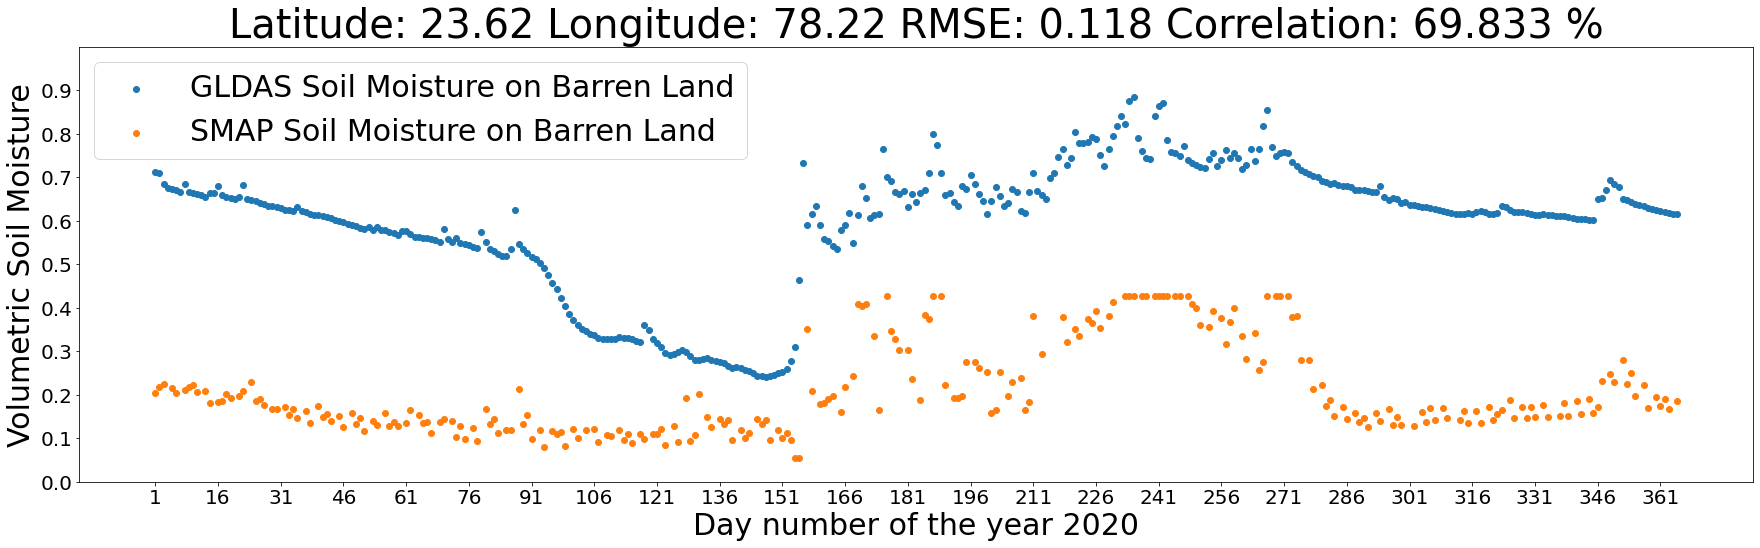

<Figure size 576x576 with 0 Axes>

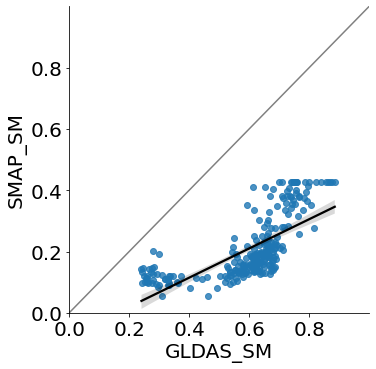

In [58]:
CR = np.array(GLDAS_SM1.corr())
CR = round((CR[2][0])*100,3)
RMSE = round(np.sum((GLDAS_SM1['GLDAS_SM'] - GLDAS_SM1['SMAP_SM'])**2)/len(GLDAS_SM1['GLDAS_SM']),3)

Plotting_Variations(GLDAS_SM1
                    ,'GLDAS_SM'
                    ,'SMAP_SM'
                    ,'GLDAS Soil Moisture on Barren Land'
                    ,'SMAP Soil Moisture on Barren Land')

+ GLDAS to SMAP has RMSE of 0.118 $m^3/m^3$ with an R-score of 69%
+ Adjusted soil moisture to SMAP has an improved RMSE of 0.059 $m^3/m^3$ with an improved R-score of 76%
+ We can see that the adjusted soil moisture has quite improvement in RMSE

### Demerits of Ulaby's WCM
+ Adjusted $E_1$ and $E_2$ are highly negative so it neglects all the terms in the model leaving $CM_v+D$.
+ This happened because of the frequency dependency of the Ulaby's model.
+ So in order to account for all the terms we need to modify the equation for GPS 1.5 GHz frequency.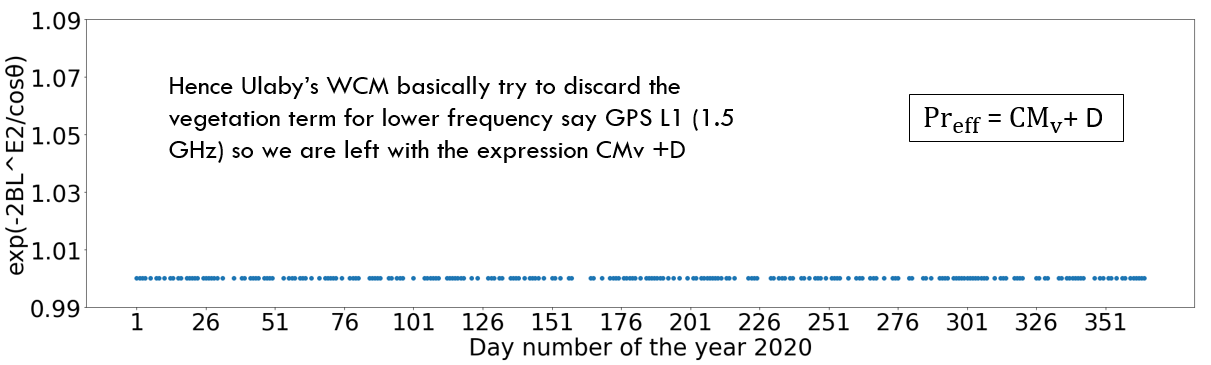

In [59]:
from IPython import get_ipython
get_ipython().magic('reset -sf')

<a id="1"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;"> Extension of Ulaby's Model </p>

#### $${𝐏r_{𝐞𝐟𝐟}} = ({{𝐂}{𝐌_𝐯}+{𝐃}})[1-{\eta_{vs}}{(1-{𝐞^{\frac{{-2}{\beta}}{𝐜𝐨𝐬𝛉}}})}]+{\sigma_{V}}{\eta_{vs}}{(1-{𝐞^{\frac{{-2}{\beta}}{𝐜𝐨𝐬𝛉}}})}$$
Where,
+ ${\beta}$ = kh
+ k = Light Extinction Coefficient
+ h = Height of the vegetation
+ $\eta_{vs}$ = Fraction of backscatter from the vegetated region
+ 𝛉 = CYGNSS specular point incidence angle
+ Preff = Backscatter from CYGNSS
+ Mv = Soil Moisture 
+ $\sigma_{V}$ = Backscatter from the Vegetated region taken as the initialization as the minimum value within the 36 Km grid cell
Where,
####  $${k}  = \frac{-ln(T)}{LAI}$$
+ LAI   = Leaf Area Index
+ T     = Transmitted light (Microwave signal) through the canopy

+ ${\eta_{vs}}{(1-{𝐞^{\frac{{-2}{\beta}}{𝐜𝐨𝐬𝛉}}})}$ varies between 0-1 same as the LAI after substituting LAI as $\beta$ in the expression
+ So we can take whole expression as LAI since LAI have same variations as this expression

### Assuming $$ {\zeta} =  {\eta_{vs}}{(1-{𝐞^{\frac{{-2}{\beta}}{𝐜𝐨𝐬𝛉}}})}$$
#### $${𝐏r_{𝐞𝐟𝐟}} = ({{𝐂}{𝐌_𝐯}+{𝐃}})(1-{\zeta})+{\sigma_{V}}{\zeta}$$
Where,
+ ${\zeta}$ = LAI
+ Preff = Backscatter from CYGNSS
+ Mv = Soil Moisture 
+ $\sigma_{V}$ = Backscatter from the Vegetated region taken as the initialization as the minimum value within the 36 Km grid cell

<a id="1"></a>
## <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;"> Non-linear least square adjustment </p>
   + Performing adjustment for the soil moisture in a particular pixel of SMAP for daily data
   + Actually number of parameters to be estimated was 4 (C, D, Sv and Mvt)
   + Minimum number of observations required should be more than 4 for the adjustment in daily data
   + So in order to account for the day with the low number of observations I have applied adjustment for whole year data
     + I have gathered those days having at least 1 observation
     + Mvt was not considered for the day having no observations
     + Parameters were nD1+nD2+2
        + Where nD1 = Number of all days soil moisture as parameters which has at least one observation
        + Where nD2 = Number of all days back-scatter from vegetation as parameters which has at least one observation

# Loading Libraries and functions

In [60]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import seaborn as sns
import sympy
from sympy import *

import Preparing_Dataset_for_BatchProcessing
import imp
imp.reload(Preparing_Dataset_for_BatchProcessing)
import Preparing_Dataset_for_BatchProcessing as r5

import matplotlib.pyplot as plt
import seaborn as sns

In [61]:
lat = 23.62   # Latitude of the centroid of the grid cell
lon = 78.22   # Longitude of the centroid of the grid cell
DF_batch = r5.Data_Batch_2020(lat,lon)
DF_batch = DF_batch[DF_batch['LAI']<1]
DF_batch[DF_batch['Day_No']==6]

,SR_eff,SP_I,sp_lat,sp_lon,LAI,Day_No
0,1.338698,12.005059,23.538832,78.059140,0.0,6.0
1,1.101488,11.969226,23.526140,78.085160,0.0,6.0
2,0.773465,11.861786,23.488018,78.163140,0.0,6.0
3,0.700457,11.825986,23.475307,78.189125,0.0,6.0
4,1.106099,11.790198,23.462587,78.215100,0.0,6.0
5,1.409840,11.754416,23.449860,78.241070,0.0,6.0


#### Resampling GLDAS data from 25 km to 36 km grid cell for initialization purpose

### Tagging the daily soil moisture their daily CYGNSS observations
+ Minimum of CYGNSS backscatter to initialize the backscatter from vegetation
+ GLDAS soil moisture to initialize the soil moisture

In [62]:
GLDAS_Path = f'D:\EG\Project Data\CYGNSS_Obs_Chambal_{lat}_{lon}'+f'\GLDAS_SM_{lat}_{lon}_Day_1-366.csv'
GLDAS_SM1  = pd.read_csv(GLDAS_Path)
GLDAS_SM1  = GLDAS_SM1.drop(np.array(GLDAS_SM1.keys())[:-1],axis=1)
GLDAS_SM   = np.array(GLDAS_SM1['GLDAS_SM'])
Mv0        = GLDAS_SM

SM_initialized = []
for i in range(len(DF_batch)):
    D = np.array(DF_batch['Day_No'])[i]-1
    SM_initialized.append(Mv0[int(D)])
DF_batch['GLDAS_SM'] = SM_initialized

def Minimum(DF_batch,D):
    DF = DF_batch[DF_batch['Day_No']==D]
    DF1 = DF['SR_eff']
    return np.min(DF1)

def Mean(DF_batch,D):
    DF = DF_batch[DF_batch['Day_No']==D]
    DF1 = DF['SR_eff']
    return np.mean(DF1)

Sv_initialized = []
for j in range(len(DF_batch)):
    D = np.array(DF_batch['Day_No'])[j]
    DF_batch1 = DF_batch[(DF_batch['Day_No']==D)]
    Sv1 = Minimum(DF_batch,D)
    Sv_initialized.append(Sv1)   

DF_batch['Sv'] = Sv_initialized
DF_batch

,SR_eff,SP_I,sp_lat,sp_lon,LAI,Day_No,GLDAS_SM,Sv
0,6.038855,23.059137,23.690813,78.065280,0.881,1.0,0.712536,4.631810
1,4.631810,23.067894,23.704811,78.091160,0.896,1.0,0.712536,4.631810
2,5.398931,23.076675,23.718813,78.117065,0.877,1.0,0.712536,4.631810
3,4.923258,23.085495,23.732817,78.142960,0.877,1.0,0.712536,4.631810
4,5.827567,23.094381,23.746794,78.168884,0.932,1.0,0.712536,4.631810
...,...,...,...,...,...,...,...,...
11,1.736492,23.198532,23.745024,78.254050,0.000,365.0,0.616134,1.018664
12,1.791297,23.174530,23.758152,78.280110,0.000,365.0,0.616134,1.018664
13,1.481883,23.150581,23.771260,78.306160,0.000,365.0,0.616134,1.018664
14,1.204441,23.126648,23.784369,78.332220,0.000,365.0,0.616134,1.018664


In [63]:
Df1 = DF_batch
DD  = (Df1['Day_No'])
DD  = DD.drop_duplicates()
DD

0       1.0
3       2.0
10      3.0
0       4.0
0       5.0
      ...  
0     361.0
3     362.0
0     363.0
0     364.0
0     365.0
Name: Day_No, Length: 243, dtype: float64

In [64]:
DF_batch['LAI'].value_counts()

0.000    2630
0.334      10
0.293       9
0.320       8
0.657       7
         ... 
0.251       1
0.345       1
0.464       1
0.199       1
0.881       1
Name: LAI, Length: 258, dtype: int64

+ So here total 243 unique days are available for adjustment
+ Therefore we will have 243 soil moisture data after adjustment

In [65]:
Sgma0    = Df1['SR_eff']       # CYGNSS back-scatter
L        = Df1['LAI']          # LAI data from NOAA
GLDAS_SM = Df1['GLDAS_SM']     # CYGNSS inclination angle 
S_v      = Df1['Sv']           # GLDAS soil moisture data for the initialization purpose
Day_No   = Df1['Day_No']       # Unique days so that the initialization tagged appropriately

### Modified Water Cloud Model Equation
$${𝐏r_{𝐞𝐟𝐟}} = ({{𝐂}{𝐌_𝐯}+{𝐃}})(1-{\zeta})+{\sigma_{V}}{\zeta}$$
Where,
+ ${\zeta}$ = LAI
+ Preff = Backscatter from CYGNSS
+ Mv = Soil Moisture 
+ $\sigma_{V}$ = Backscatter from the Vegetated region taken as the initialization as the minimum value within the 36 Km grid cell

In [66]:
# Creating Variables
Sv, l, c, d, Mvt, Sgma = symbols('Sv l c d Mvt Sgma')

# Modified Water Cloud Model Equation
f   = Sgma-(Sv*l+(c*Mvt+d)*(1-l))
f

Sgma - Sv*l - (1 - l)*(Mvt*c + d)

### Model Parameters (n, u, r, P)
+ n = number of observations
+ r = redundancy 
+ u = number of unknowns
+ P = weight matrix (assumed as identity giving equal weights to all the observations)

In [67]:
def Adjustment_Parameters1(Sgma0,DD):
    P = np.identity(len(Sgma0))         # Weight matrix (Precision matrix)
    n = len(Sgma0)                      # As total n erroneous observations are there  
    u = 2+2*len(DD)  # C, D, Svt6, ..., Svt365, Mvt6, ..., Mvt365 Assume those day soil moisture only having Biomass
    r = n-u          # Redundancy
    return P,n,u,r

P,n,u,r = Adjustment_Parameters1(Sgma0,DD)
u1 = int((u-2)/2)
P,n,u,r,u1

(array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 1.]]),
 3198,
 488,
 2710,
 243)

### Generating Design Matrix
#### Deriving the Jacobian

In [68]:
%%time
def Der(f,var):
    A1 = (Derivative(f,var)).doit()
    return A1

def Design_Matrix1(Df1,Sv,c,d,Mvt,DD):
    C1 = Der(f,Sv)
    C2 = Der(f,c)
    C3 = Der(f,d)
    A1 = []
    for j in range(len(Df1)):
        Single_Row_A = []
        for i in range(len(DD)):
            d1 = np.array(DD)[i]
            d2 = int(np.array(Df1['Day_No'])[j])
            if d1 == d2:
                Single_Row_A += [C1]
            else:
                Single_Row_A += [0]
                
        Single_Row_A += [C2]
        Single_Row_A += [C3]
        A1 += Single_Row_A
    A2 = np.array(A1)
    A1 = A2.reshape(len(Df1),(len(DD)+2))  
    return A1

def Design_Matrix2(Df1,Sv,c,d,Mvt,DD):
    C4 = Der(f,Mvt)
    A1 = []
    for j in range(len(Df1)):
        Single_Row_A = []
        for i in range(len(DD)):
            d1 = np.array(DD)[i]
            d2 = int(np.array(Df1['Day_No'])[j])
            if d1 == d2:
                Single_Row_A += [C4]
            else:
                Single_Row_A += [0]
        A1 += Single_Row_A
    A2 = np.array(A1)
    A1 = A2.reshape(len(Df1),len(DD))  
    return A1

def Design_Matrix(Df1,Sv,c,d,Mvt,DD):
    A1 = Design_Matrix1(Df1,Sv,c,d,Mvt,DD)
    A1 = pd.DataFrame(A1)
    
    A2 = Design_Matrix2(Df1,Sv,c,d,Mvt,DD)
    A2 = pd.DataFrame(A2)
    
    A  = pd.concat([A1, A2], axis=1)
    return np.array(A)

A1 = Design_Matrix(Df1,Sv,c,d,Mvt,DD)
pd.DataFrame(A1)

Wall time: 24.6 s


,0,1,2,3,4,5,6,7,8,9,...,478,479,480,481,482,483,484,485,486,487
0,-l,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-l,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-l,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-l,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-l,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3193,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,c*(l - 1)
3194,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,c*(l - 1)
3195,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,c*(l - 1)
3196,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,c*(l - 1)


### Substituting values in Jacobian to get the design matrix

In [69]:
def Resubstituting_Values(A1,Sgma0,L,S_v,SM_GLDAS,c0,d0):
    n1,n2 = A1.shape
    A_1   = []
    for i in range(n1):
        Sgma1  = np.array(Sgma0)[i]
        L1     = np.array(L)[i]
        Mv0    = np.array(SM_GLDAS)[i]
        Sv0    = np.array(S_v)[i]
        for j in range(n2):
            a1 = A1[i][j]
            if a1!=0:
                aij = a1.subs({Sgma:Sgma1,l:L1,Sv:Sv0,Mvt:Mv0,c:c0,d:d0})
                A_1.append(aij)
            else:
                A_1.append(0)
    A_1 = np.array(A_1)    
    A1  = A_1.reshape(n1,n2)
    A   = np.array(A1)
    return A

### Setting initial values to the Model parameters 
+ Used Hit and Trail Method to approximate these values

In [70]:
c0    = 20
d0    = -1

### Adding the initialized soil moisture 

In [71]:
DFT        = DF_batch.drop_duplicates(subset=['Day_No'])
SM_initial = np.array(DFT['GLDAS_SM'])
Sv_initial = np.array(DFT['Sv'])

X0         = []
for i in range(len(Sv_initial)):
    X0.append(Sv_initial[i])
    
X0.append(c0)
X0.append(d0)
for i in range(len(SM_initial)):
    X0.append(SM_initial[i])
pd.DataFrame(X0)

,0
0,4.631810
1,1.703947
2,2.791710
3,2.054713
4,1.437340
...,...
483,0.623587
484,0.619572
485,0.617998
486,0.616732


+ X0 is the initial parameter vector

In [72]:
%%time
A = Resubstituting_Values(A1,Sgma0,L,S_v,GLDAS_SM,c0,d0)
pd.DataFrame(A)

Wall time: 7.71 s


,0,1,2,3,4,5,6,7,8,9,...,478,479,480,481,482,483,484,485,486,487
0,-0.881000000000000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-0.896000000000000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-0.877000000000000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-0.877000000000000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-0.932000000000000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3193,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-20
3194,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-20
3195,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-20
3196,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-20


In [73]:
A = pd.DataFrame(A)
A.to_csv(rf'D:\EG\Project Data\LAI_Obsvn_Adjustment_Params\A_{lat}_{lon}.csv',index = False)
A = pd.read_csv(rf'D:\EG\Project Data\LAI_Obsvn_Adjustment_Params\A_{lat}_{lon}.csv')
A = (np.array(A))

### Deriving the residual matrix

In [74]:
%%time
def Misclosure(Sgma0,L,S_v,SM_GLDAS,c0,d0,f):
    W_0 = []
    for i in range(len(Sgma0)):
        Sgma1  = np.array(Sgma0)[i]
        L1     = np.array(L)[i]
        Mv0    = np.array(SM_GLDAS)[i]
        Sv0    = np.array(S_v)[i]
        f5 = f.subs({Sgma:Sgma1,l:L1,Sv:Sv0,Mvt:Mv0,c:c0,d:d0})
        W_0.append(f5)
    W_0 = np.array(W_0)
    W1 = W_0.reshape(len(Sgma0),1)
    return W1

W = Misclosure(Sgma0,L,S_v,GLDAS_SM,c0,d0,f)
W = pd.DataFrame(W)
W.to_csv(rf'D:\EG\Project Data\LAI_Obsvn_Adjustment_Params\W_{lat}_{lon}.csv',index = False)
W = pd.read_csv(rf'D:\EG\Project Data\LAI_Obsvn_Adjustment_Params\W_{lat}_{lon}.csv')
W = (np.array(W))

Wall time: 6.83 s


### Deriving the normal matrix

In [75]:
%%time
N = np.array(np.transpose(A)@P@A)

# Converting the elements of the matrix from the object to the float
def Object_toFloat(Matrix):
    m,n = Matrix.shape
    M1 = []
    for i in range(m):
        for j in range(n):
            M1.append(float(Matrix[i,j]))
    M2 = np.array(M1)
    M = M2.reshape(m,n)
    return M

N = Object_toFloat(N)
N = pd.DataFrame(N) 
N

Wall time: 257 ms


,0,1,2,3,4,5,6,7,8,9,...,478,479,480,481,482,483,484,485,486,487
0,3.985859,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0,0.0000,0.0
1,0.000000,3.812341,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0,0.0000,0.0
2,0.000000,0.000000,0.613089,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0,0.0000,0.0
3,0.000000,0.000000,0.000000,0.919681,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0,0.0000,0.0
4,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0,0.0000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,515.7076,0.0000,0.0,0.0000,0.0
484,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0000,87.4588,0.0,0.0000,0.0
485,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,1200.0,0.0000,0.0
486,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0,3600.0392,0.0


In [76]:
%%time
U = (np.transpose(A))@P@W
U

Wall time: 134 ms


array([[ 8.30013907e-01],
       [ 5.30379747e-02],
       [ 1.68233137e+00],
       [-4.92980833e-01],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [-4.22771995e-01],
       [-2.36652673e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 1.27743009e+00],
       [-2.88373820e-02],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 5.67145640e-01],
       [ 0.00000000e+00],
       [ 2.23520484e+00],
       [ 1.71881065e+00],
       [ 9.81947872e-01],
       [ 2.03157260e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 1.18305246e-01],
       [ 0.00000000e+00],
       [ 1.12692237e+01],
       [ 4.58369130e+00],
       [ 1.78007316e+00],
       [ 0.00000000e+00],
       [-7.69630631e+00],
       [ 2.71648392e+01],
       [ 7.51028553e+00],
       [ 0.00000000e+00],
       [ 0.0

### Updates in initialized parameters

In [77]:
Part1  = np.linalg.pinv(N)       ## Inverse of N
Part2  = Object_toFloat(Part1)   ## Converting elements to float
dX     = -Part2@U                ## Change in X
np.max(abs(dX))

313.01315890502883

In [78]:
X0 = np.array(X0)
X0 = X0.reshape(len(X0),1)
X  = X0+dX
X

array([[ 6.06580378e+00],
       [ 3.23466188e+00],
       [ 2.73520276e+00],
       [ 2.93643010e+00],
       [ 1.43733441e+00],
       [ 7.00459305e-01],
       [ 1.85173674e+00],
       [ 4.54078155e+00],
       [ 1.44108545e+00],
       [ 7.96217852e-01],
       [ 3.75607716e+00],
       [ 6.62930491e-01],
       [ 1.32641249e+00],
       [ 9.14973766e-01],
       [ 9.37871688e-01],
       [ 6.09714694e-01],
       [ 9.19912587e-01],
       [ 1.36140181e+00],
       [ 1.73125833e+00],
       [ 3.20962570e+00],
       [ 3.04166017e+00],
       [ 2.35074570e+00],
       [ 7.45419405e-01],
       [ 9.80288992e-01],
       [ 1.29229195e+00],
       [ 1.87419217e+00],
       [ 2.61742341e+00],
       [ 1.92101323e+00],
       [ 1.00825077e+01],
       [ 8.42816421e-01],
       [ 1.05112926e+00],
       [ 2.03799346e+00],
       [ 2.58804925e+00],
       [ 7.88920709e-01],
       [ 2.46429267e+00],
       [ 3.12265291e+00],
       [ 1.83640054e+00],
       [ 1.34256315e+00],
       [ 1.0

### Creating Index for updating parameters

In [79]:
Df = pd.DataFrame(DF_batch['Day_No'].value_counts(sort=False))['Day_No']
DD = Df.values
idx = []
m = 0
for i in range(len(DD)):
    j = DD[i]
    for k in range(j):
        idx.append(m)
    m = m+1
np.array(idx).shape

(3198,)

## 1st Iteration

In [80]:
X_SM = X[u1+2:]
X_Sv = X[:u1+2]
X_SM.shape,X_Sv.shape

((243, 1), (245, 1))

### Updating soil moisture and back-scatter from vegetation

In [81]:
Mv0 = X_SM
DF_batch1 = DF_batch.drop(['GLDAS_SM'], axis=1)
Mv0

array([[ 0.20047033],
       [ 0.31629248],
       [ 0.37142813],
       [ 0.4431269 ],
       [ 0.34406678],
       [ 0.27406237],
       [ 0.21094333],
       [ 0.39960163],
       [ 0.33907413],
       [ 0.39125949],
       [ 0.42321452],
       [ 0.45792019],
       [ 0.70212357],
       [ 0.2821439 ],
       [ 0.32192413],
       [ 0.2758911 ],
       [ 0.4262093 ],
       [ 0.29166325],
       [ 0.28164263],
       [ 0.30846219],
       [ 0.20050773],
       [ 0.35262151],
       [ 0.32897573],
       [ 0.29544355],
       [ 0.35150679],
       [ 0.36774683],
       [ 0.34650054],
       [ 0.35992791],
       [ 0.71217621],
       [ 0.33375438],
       [ 0.27611925],
       [ 0.45105842],
       [ 0.19186545],
       [ 0.29129664],
       [ 0.60132137],
       [ 0.14480724],
       [ 0.19125817],
       [ 0.34175884],
       [ 0.32916974],
       [ 0.25635744],
       [ 0.28096475],
       [ 0.41736397],
       [ 0.3143892 ],
       [ 0.5238789 ],
       [ 0.29846175],
       [ 0

In [82]:
def New_SM(DF_batch,X_Sv,X_SM,idx):
    Mv0 = X_SM
    DF_batch1 = DF_batch.drop(['GLDAS_SM'], axis=1)
    SM_initialized = []
    for i in range(len(DF_batch1)):
        D  = int(np.array(idx)[i])
        SM = Mv0[D]
        SM_initialized.append(SM)
    SM_initialized = np.array(SM_initialized).reshape(len(SM_initialized),) 
    
    Mv0 = X_Sv
    DF_batch2 = DF_batch.drop(['Sv'], axis=1)
    Sv_initialized = []
    for j in range(len(DF_batch2)):
        D  = int(np.array(idx)[j])
        Sv = Mv0[D]
        Sv_initialized.append(Sv)
    Sv_initialized = np.array(Sv_initialized).reshape(len(Sv_initialized),) 
    return SM_initialized, Sv_initialized

In [83]:
%%time
GLDAS_SM,S_v = New_SM(DF_batch,X_Sv,X_SM,idx)
A            = Resubstituting_Values(A1,Sgma0,L,S_v,GLDAS_SM,X[u1][0],X[u1+1][0])
A            = pd.DataFrame(A)
A.to_csv(rf'D:\EG\Project Data\LAI_Obsvn_Adjustment_Params\A_{lat}_{lon}.csv',index = False)
A            = pd.read_csv(rf'D:\EG\Project Data\LAI_Obsvn_Adjustment_Params\A_{lat}_{lon}.csv')
A            = (np.array(A))
W            = Misclosure(Sgma0,L,S_v,GLDAS_SM,X[u1][0],X[u1+1][0],f)
W            = pd.DataFrame(W)
W.to_csv(rf'D:\EG\Project Data\LAI_Obsvn_Adjustment_Params\W_{lat}_{lon}.csv',index = False)
W            = pd.read_csv(rf'D:\EG\Project Data\LAI_Obsvn_Adjustment_Params\W_{lat}_{lon}.csv')
W            = (np.array(W))
N            = np.array(np.transpose(A)@P@A)
U            = (np.transpose(A))@P@W
N            = Object_toFloat(N)
Part1        = np.linalg.pinv(N)       ## Inverse of N
Part2        = Object_toFloat(Part1)   ## Converting elements to float
dX1          = -Part2@U                ## Change in X

Wall time: 20.1 s


#### Setting threshold to stop the adjustment

In [84]:
np.max(abs(dX1-dX))<10**(-5)

False

+ Subsequent change in the parameters is more than the threshold so we need to perform more iterations here

#### Updated parameters for next iteration

In [85]:
X = X+dX1
X

array([[ 6.06580378e+00],
       [ 3.23466188e+00],
       [ 2.73133471e+00],
       [ 2.93643010e+00],
       [ 1.43733441e+00],
       [ 7.00459305e-01],
       [ 1.85173674e+00],
       [ 4.54078155e+00],
       [ 1.44108545e+00],
       [ 7.96217852e-01],
       [ 3.75607716e+00],
       [ 6.56882267e-01],
       [ 1.33042917e+00],
       [ 9.14973766e-01],
       [ 9.37871688e-01],
       [ 6.09714694e-01],
       [ 9.13865668e-01],
       [ 1.36140181e+00],
       [ 1.73125833e+00],
       [ 3.20962570e+00],
       [ 3.04166017e+00],
       [ 2.35074570e+00],
       [ 7.45419405e-01],
       [ 9.80288992e-01],
       [ 1.29229195e+00],
       [ 1.87419217e+00],
       [ 2.61742341e+00],
       [ 1.92101323e+00],
       [ 1.00859052e+01],
       [ 8.42816421e-01],
       [ 1.05112926e+00],
       [ 2.03728014e+00],
       [ 2.58804925e+00],
       [ 7.88920709e-01],
       [ 2.46429267e+00],
       [ 3.12265291e+00],
       [ 1.83640054e+00],
       [ 1.34256315e+00],
       [ 1.0

### Performing more Iteration

In [86]:
def Adjustment_Parameters(DF_batch,idx,A1,Sgma0,L,X,f):
    X_SM = X[u1+2:]
    X_Sv = X[:u1]
    GLDAS_SM,S_v = New_SM(DF_batch,X_Sv,X_SM,idx)
    A        = Resubstituting_Values(A1,Sgma0,L,S_v,GLDAS_SM,X[u1][0],X[u1+1][0])
    A        = pd.DataFrame(A)
    A.to_csv(rf'D:\EG\Project Data\LAI_Obsvn_Adjustment_Params\A_{lat}_{lon}.csv',index = False)
    A        = pd.read_csv(rf'D:\EG\Project Data\LAI_Obsvn_Adjustment_Params\A_{lat}_{lon}.csv')
    A        = (np.array(A))
    W        = Misclosure(Sgma0,L,S_v,GLDAS_SM,X[u1][0],X[u1+1][0],f)
    W        = pd.DataFrame(W)
    W.to_csv(rf'D:\EG\Project Data\LAI_Obsvn_Adjustment_Params\W_{lat}_{lon}.csv',index = False)
    W        = pd.read_csv(rf'D:\EG\Project Data\LAI_Obsvn_Adjustment_Params\W_{lat}_{lon}.csv')
    W        = (np.array(W))
    N        = np.array(np.transpose(A)@P@A)
    U        = (np.transpose(A))@P@W
    N        = Object_toFloat(N)
    Part1    = np.linalg.pinv(N)       ## Inverse of N
    Part2    = Object_toFloat(Part1)   ## Converting elements to float
    dX       = -Part2@U                ## Change in X
    return A,W,N,U,dX

dX = dX1
for i in range(1,200):
    A,W,N,U,dX1 = Adjustment_Parameters(DF_batch,idx,A1,Sgma0,L,X,f)
    Thres       = np.max(abs(dX-dX1))
    if Thres<10**(-5):
        A_adjusted  = A
        W_adjusted  = W
        N_adjusted  = N
        U_adjusted  = U
        X_adjusted  = X
        dX_adjusted = dX
        Number_Iteration = i
        break
    else:
        dX = dX1
        X  = X+dX
        
A_adjusted  = pd.DataFrame(A_adjusted)
W_adjusted  = pd.DataFrame(W_adjusted)
N_adjusted  = pd.DataFrame(N_adjusted)
U_adjusted  = pd.DataFrame(U_adjusted)
X_adjusted  = pd.DataFrame(X_adjusted)
dX_adjusted = pd.DataFrame(dX_adjusted)
Thres_Iter  = pd.DataFrame(np.array([Thres,Number_Iteration+1]))

A_adjusted.to_csv(rf'D:\EG\Project Data\LAI_Obsvn_Adjustment_Params\A_adjusted_{lat}_{lon}.csv',index = False)
W_adjusted.to_csv(rf'D:\EG\Project Data\LAI_Obsvn_Adjustment_Params\W_adjusted_{lat}_{lon}.csv',index = False)
N_adjusted.to_csv(rf'D:\EG\Project Data\LAI_Obsvn_Adjustment_Params\N_adjusted_{lat}_{lon}.csv',index = False)
U_adjusted.to_csv(rf'D:\EG\Project Data\LAI_Obsvn_Adjustment_Params\U_adjusted_{lat}_{lon}.csv',index = False)
X_adjusted.to_csv(rf'D:\EG\Project Data\LAI_Obsvn_Adjustment_Params\X_adjusted_{lat}_{lon}.csv',index = False)
dX_adjusted.to_csv(rf'D:\EG\Project Data\LAI_Obsvn_Adjustment_Params\dX_adjusted_{lat}_{lon}.csv',index = False)
Thres_Iter.to_csv(rf'D:\EG\Project Data\LAI_Obsvn_Adjustment_Params\Thres_Iter_{lat}_{lon}.csv',index = False)

A_adjusted  = (np.array(pd.read_csv(rf'D:\EG\Project Data\LAI_Obsvn_Adjustment_Params\A_adjusted_{lat}_{lon}.csv')))
W_adjusted  = (np.array(pd.read_csv(rf'D:\EG\Project Data\LAI_Obsvn_Adjustment_Params\W_adjusted_{lat}_{lon}.csv')))
N_adjusted  = (np.array(pd.read_csv(rf'D:\EG\Project Data\LAI_Obsvn_Adjustment_Params\N_adjusted_{lat}_{lon}.csv')))
U_adjusted  = (np.array(pd.read_csv(rf'D:\EG\Project Data\LAI_Obsvn_Adjustment_Params\U_adjusted_{lat}_{lon}.csv')))
X_adjusted  = (np.array(pd.read_csv(rf'D:\EG\Project Data\LAI_Obsvn_Adjustment_Params\X_adjusted_{lat}_{lon}.csv')))
dX_adjusted = (np.array(pd.read_csv(rf'D:\EG\Project Data\LAI_Obsvn_Adjustment_Params\dX_adjusted_{lat}_{lon}.csv')))
Thres_Iter  = (np.array(pd.read_csv(rf'D:\EG\Project Data\LAI_Obsvn_Adjustment_Params\Thres_Iter_{lat}_{lon}.csv')))

print('Threshold = ',Thres_Iter[0][0])
print('Number of Iterations = ',Thres_Iter[1][0])
A = pd.DataFrame(A_adjusted) 
A

Threshold =  4.0993545795968215e-09
Number of Iterations =  4.0


,0,1,2,3,4,5,6,7,8,9,...,478,479,480,481,482,483,484,485,486,487
0,-0.881,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,-0.896,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,-0.877,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,-0.877,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,-0.932,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3193,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-18.445886
3194,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-18.445886
3195,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-18.445886
3196,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-18.445886


In [87]:
W = pd.DataFrame(W_adjusted) 
W

,0
0,0.750562
1,-0.754489
2,0.136773
3,-0.338901
4,0.206055
...,...
3193,0.316547
3194,0.371351
3195,0.061938
3196,-0.215504


In [88]:
N = pd.DataFrame(N_adjusted) 
N

,0,1,2,3,4,5,6,7,8,9,...,478,479,480,481,482,483,484,485,486,487
0,3.985859,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,3.812341,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.613089,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.919681,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,438.674702,0.000000,0.000000,0.000000,0.000000
484,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,74.394799,0.000000,0.000000,0.000000
485,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1020.752152,0.000000,0.000000
486,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,3062.289801,0.000000


In [89]:
X = pd.DataFrame(X_adjusted) 
X

,0
0,6.065804
1,3.234662
2,2.731341
3,2.936430
4,1.437334
...,...
483,0.643073
484,0.075380
485,0.273174
486,0.261176


In [90]:
dX = pd.DataFrame(dX_adjusted)
dX

,0
0,1.135785e-14
1,-4.250966e-15
2,3.185747e-11
3,2.532641e-16
4,-1.460879e-19
...,...
483,-1.376518e-10
484,3.679851e-10
485,1.888170e-10
486,1.983136e-10


### Design Matrix Corresponding to WCM Parameters

In [91]:
pd.DataFrame(X[:u1+2])

,0
0,6.065804
1,3.234662
2,2.731341
3,2.936430
4,1.437334
...,...
240,0.624446
241,1.044224
242,1.018665
243,18.445886


In [92]:
pd.DataFrame(A_adjusted[:,:u1+2])

,0,1,2,3,4,5,6,7,8,9,...,235,236,237,238,239,240,241,242,243,244
0,-0.881,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.019421,-0.119
1,-0.896,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.016973,-0.104
2,-0.877,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.020074,-0.123
3,-0.877,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.020074,-0.123
4,-0.932,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.011098,-0.068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3193,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.265547,-1.000
3194,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.265547,-1.000
3195,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.265547,-1.000
3196,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.265547,-1.000


### Design Matrix corresponding to the Soil Moisture

In [93]:
pd.DataFrame(X[u1+2:])

,0
245,0.163202
246,0.288977
247,0.351724
248,0.429418
249,0.322224
...,...
483,0.643073
484,0.075380
485,0.273174
486,0.261176


In [94]:
pd.DataFrame(A_adjusted[:,u1+2:])

,0,1,2,3,4,5,6,7,8,9,...,233,234,235,236,237,238,239,240,241,242
0,-2.195060,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,-1.918372,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,-2.268844,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,-2.268844,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,-1.254320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3193,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-18.445886
3194,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-18.445886
3195,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-18.445886
3196,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-18.445886


<a id="1"></a>
## <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:4px 4px;">Hypothesis Test</p>

In [95]:
S   = np.transpose(W)@P@W/r       ## Sum of the square of the residuals
S02 = np.std(Sgma0)               ## Standard deviation in original observed backscatter
r

2710

+ For 5 % significance level 
  + From look up table critical value:
    + DOF = r , alpha = 0.05
    + Critical value, P = r-1 

In [96]:
Test_Statistic = r*S02/S[0][0]
P = r-1
Test_Statistic<P,Test_Statistic

(True, 1612.851609920013)

+ Test statistic is less than critical value 

### Orthogonality Test 

In [97]:
V = np.transpose(A)@W 
np.sum(V**2)<10**(-20),np.sum(V**2)

(0    True
 dtype: bool,
 0    2.490701e-23
 dtype: float64)

<a id="1"></a>
## <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:4px 4px;">Validation of Adjusted Soil Moisture</p>

# 1. Correlation of adjusted with SMAP soil moisture

In [98]:
DD1 = DF_batch['Day_No'].drop_duplicates()
DD  = DD1.values
SM_adjusted = X[u1+2:].values

SMAP_SM = pd.read_csv(f'D:\EG\Project Data\CYGNSS_Data_in_0p36Dg\SMAP_RF_SM\SMAP_SM_Variations_{lat}_{lon}.csv')  
SMAP_SM['SMAP_SM'] = SMAP_SM['SMAP_SM']/100
x2  = np.array(SMAP_SM['SMAP_SM'])

SMAP_SM_filter = []
for j in range(len(DD)):
    D2 = int(DD[j])
    SMAP_SM_filter.append(np.array(SMAP_SM['SMAP_SM'])[D2-1])
    
Df = pd.DataFrame(DD)
Df.columns = ['Day_No'] 
Df['SMAP_SM'] = SMAP_SM_filter
Df['Improved_SM'] = SM_adjusted
Df = Df[(Df['Improved_SM']<0.8) & (Df['Improved_SM']>=0)]

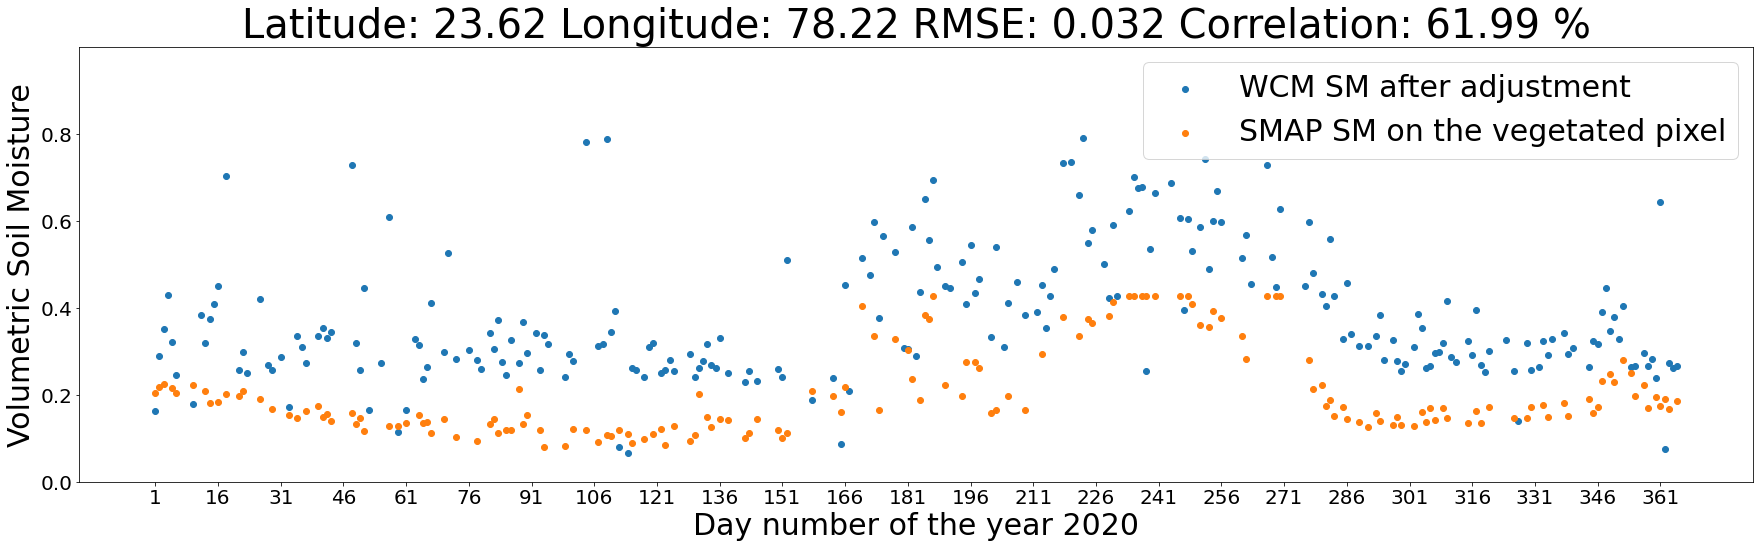

<Figure size 576x576 with 0 Axes>

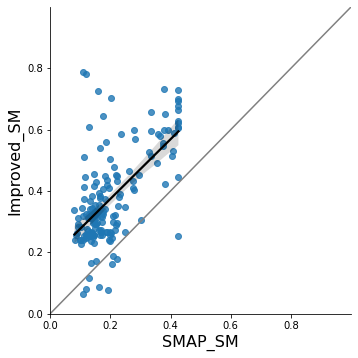

In [100]:
def Plotting_Var(Df,lat,lon):
    CR = np.array(Df.corr())[1][2]*100
    RMSE = round(np.sum((Df['SMAP_SM'] - Df['Improved_SM'])**2)/len(Df['SMAP_SM']),3)
    plt.figure(figsize=(30,8))
    plt.scatter(Df['Day_No'],Df['Improved_SM'],label='WCM SM after adjustment')
    plt.scatter(Df['Day_No'],Df['SMAP_SM'],label='SMAP SM on the vegetated pixel')
    
    plt.title(f'''Latitude: {lat} Longitude: {lon} RMSE: {round(RMSE,4)} Correlation: {np.round(CR,2)} %''',size=40) 
    plt.xlabel('Day number of the year 2020',size=30)
    plt.ylabel('Volumetric Soil Moisture',size=30)
    plt.ylim(0,1)
    plt.xticks(np.arange(1, 370, 15),size=20)
    plt.yticks(np.arange(0, 1, 0.2),size=20)
    plt.legend(fontsize=30)

    plt.figure(figsize=(8,8))
    sns.lmplot(x=f'SMAP_SM',y=f'Improved_SM',data=Df,line_kws={'color': 'black'})
    plt.xlabel(f'SMAP_SM',size=16)
    plt.ylabel(f'Improved_SM',size=16)
    plt.plot([0,1],[0,1],c='gray')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xticks(np.arange(0, 1, 0.2))
    plt.yticks(np.arange(0, 1, 0.2))
    
def Plotting_Variations(Df,Var1,Var2,label1,label2):
    plt.figure(figsize=(30,8))
    plt.scatter(Df['Day_No'],Df[f'{Var1}'],label = label1)
    plt.scatter(Df['Day_No'],Df[f'{Var2}'],label = label2)
    
    plt.title(f'''Latitude: {lat} Longitude: {lon} RMSE: {round(RMSE,4)} Correlation: {CR} %''',size=40) 
    plt.xlabel('Day number of the year 2020',size=30)
    plt.ylabel('Volumetric Soil Moisture',size=30)
    plt.ylim(0,1)
    plt.xticks(np.arange(1, 370, 15),size=20)
    plt.yticks(np.arange(0, 1, 0.1),size=20)
    plt.legend(fontsize=30)
    
    plt.figure(figsize=(8,8))
    sns.lmplot(x=f'{Var1}',y=f'{Var2}',data=Df,line_kws={'color': 'black'})
    plt.xlabel(f'{Var1}',size=20)
    plt.ylabel(f'{Var2}',size=20)
    plt.plot([0,1],[0,1],c='gray')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xticks(np.arange(0, 1, 0.2),size=20)
    plt.yticks(np.arange(0, 1, 0.2),size=20)
Plotting_Var(Df,lat,lon)

# 2. Correlation of adjusted with GLDAS soil moisture

In [101]:
def New_SM1(DF_batch,X_SM,idx):
    Mv0 = X_SM
    SM_initialized = []
    for i in range(len(DF_batch)):
        D  = int(np.array(idx)[i])
        SM = float(Mv0[D])
        SM_initialized.append(SM)
    SM_initialized = np.array(SM_initialized).reshape(len(SM_initialized),) 
    DF_batch['WCM_SM'] = SM_initialized
    return DF_batch

X_SM     = X[u1+2:].values
GLDAS_WCM_SM = New_SM1(DF_batch,X_SM,idx)
GLDAS_WCM_SM1 = GLDAS_WCM_SM.drop(['SR_eff','SP_I','sp_lat','sp_lon','LAI'], axis=1)
GLDAS_WCM_SM1 = GLDAS_WCM_SM1.drop_duplicates()
GLDAS_WCM_SM1['Sv'] = GLDAS_WCM_SM1['Sv']/20
GLDAS_WCM_SM1 = GLDAS_WCM_SM1[(GLDAS_WCM_SM1['WCM_SM']<0.8)]
GLDAS_WCM_SM1 = GLDAS_WCM_SM1[(GLDAS_WCM_SM1['WCM_SM']>0)]
GLDAS_WCM_SM1.corr()

,Day_No,GLDAS_SM,Sv,WCM_SM
Day_No,1.000000,0.344890,0.045282,0.132926
GLDAS_SM,0.344890,1.000000,0.411082,0.470217
Sv,0.045282,0.411082,1.000000,0.759628
WCM_SM,0.132926,0.470217,0.759628,1.000000


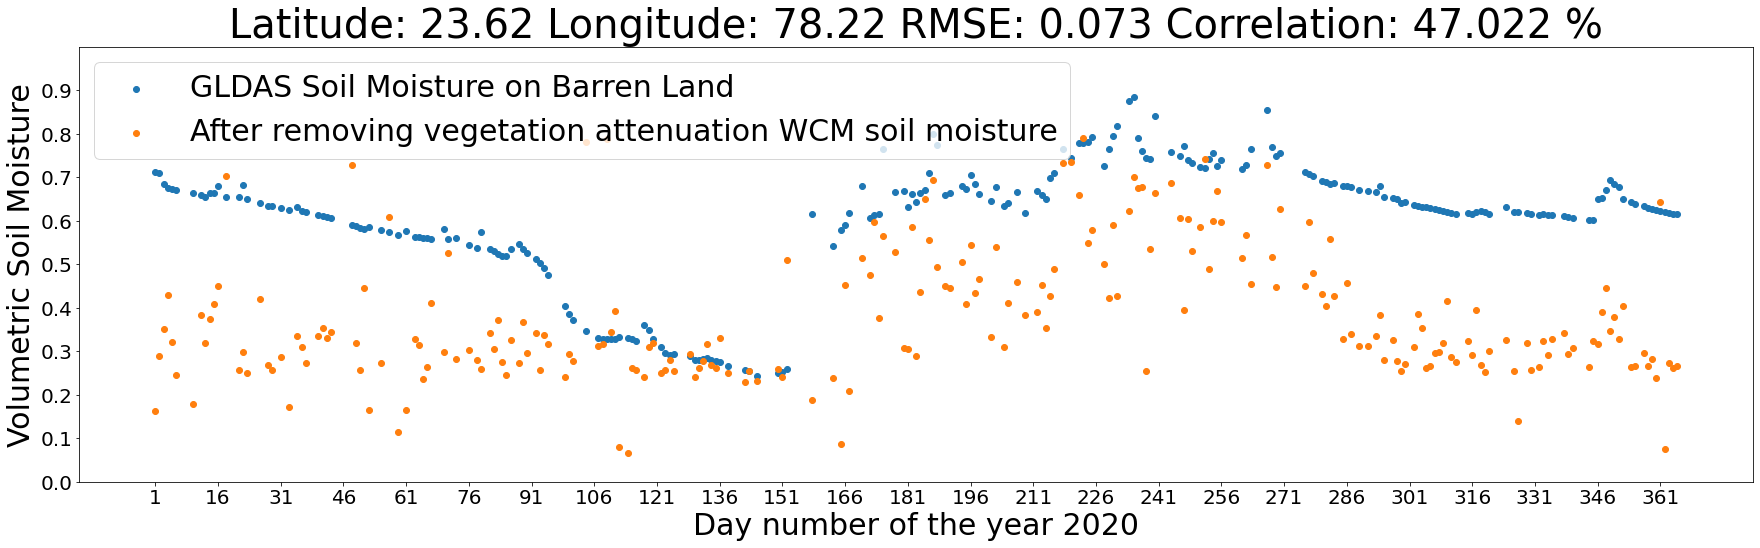

<Figure size 576x576 with 0 Axes>

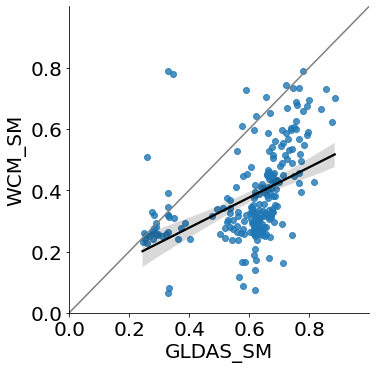

In [102]:
CR   = np.array(GLDAS_WCM_SM1.corr())
CR   = round((CR[1][3])*100,3)
RMSE = round(np.sum((GLDAS_WCM_SM1['GLDAS_SM'] - GLDAS_WCM_SM1['WCM_SM'])**2)/len(GLDAS_WCM_SM1['GLDAS_SM']),3)

Plotting_Variations(GLDAS_WCM_SM1
                    ,'GLDAS_SM'
                    ,'WCM_SM'
                    ,'GLDAS Soil Moisture on Barren Land'
                    ,'After removing vegetation attenuation WCM soil moisture')

# 3. Correlation of adjusted vegetation back-scatter with GLDAS soil moisture

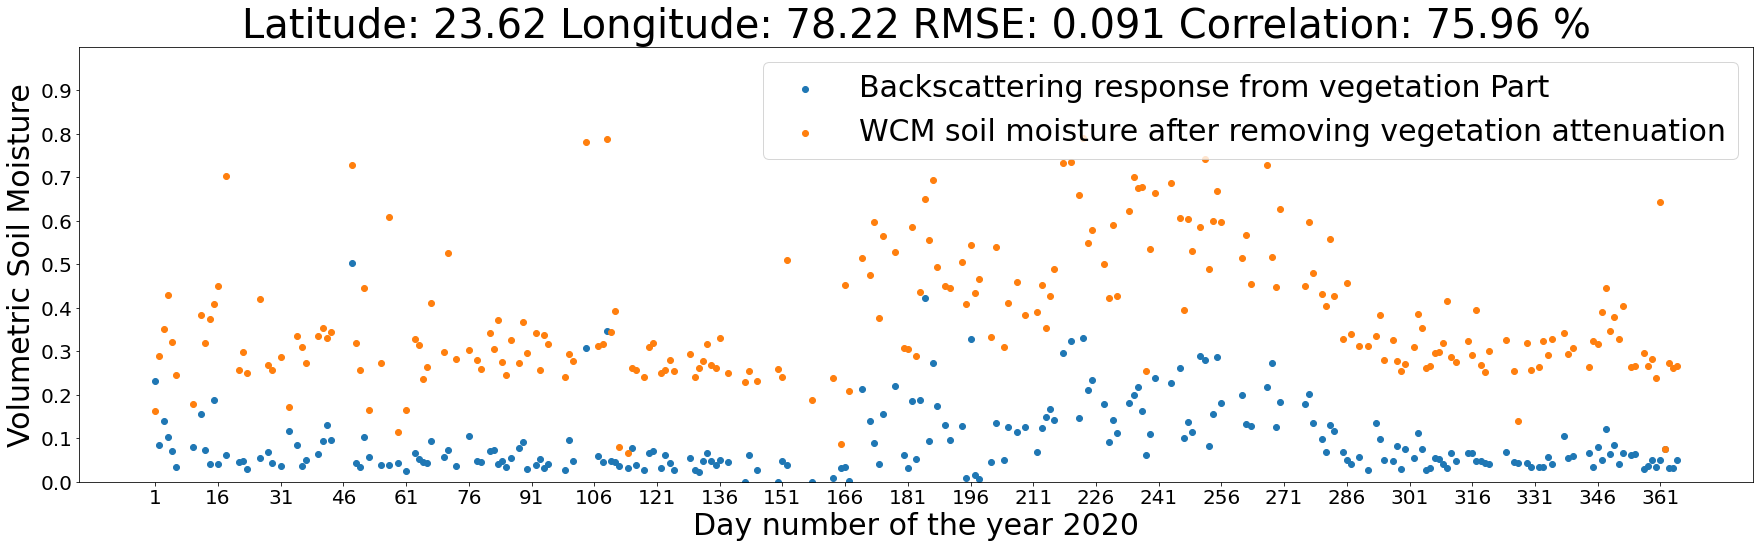

<Figure size 576x576 with 0 Axes>

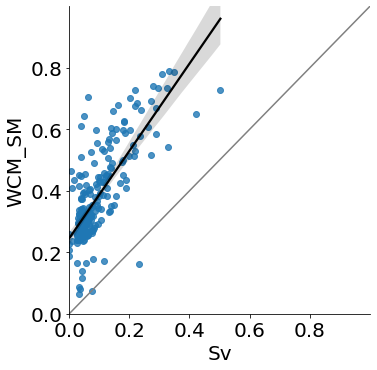

In [103]:
CR   = np.array(GLDAS_WCM_SM1.corr())
CR   = round((CR[2][3])*100,2)
RMSE = round(np.sum((GLDAS_WCM_SM1['Sv'] - GLDAS_WCM_SM1['WCM_SM'])**2)/len(GLDAS_WCM_SM1['Sv']),3)

Plotting_Variations(GLDAS_WCM_SM1
                    ,'Sv'
                    ,'WCM_SM'
                    ,'Backscattering response from vegetation Part'
                    ,'WCM soil moisture after removing vegetation attenuation')

# Conclusion

+ Developed modified water cloud model
+ GLDAS to SMAP has RMSE of 0.118 $m^3/m^3$ with an R-score of 69%
+ We can see that the adjusted soil moisture has quite improvement in RMSE
+ The RMSE is improved from 0.059 to 0.032 $m^3/m^3$